In [3]:
from commonfunctions import *
import cv2  as cv
import imutils
import numpy as np
import pandas as pd 
from joblib import load

from skimage.filters import threshold_local
from skimage import measure
from skimage.feature import hog
import os

In [4]:
def calculate_contour_distance(contour1, contour2): # 
    x1, y1, w1, h1 = cv.boundingRect(contour1)
    c_x1 = x1 + w1
    c_y1 = y1 + h1/2

    x2, y2, w2, h2 = cv.boundingRect(contour2)
    c_x2 = x2 
    c_y2 = y2 + h2/2
    
    if c_x1 > c_x2:
        c_x1 = x1
        c_x2 = x2 + w2

    
    return (abs(c_x1 - c_x2) , abs(c_y1 - c_y2))

def merge_contours(contour1, contour2):
    return np.concatenate((contour1, contour2), axis=0)

def agglomerative_cluster(contours, threshold_distance=20):
    current_contours = contours
    while len(current_contours) > 1:
        min_distance = None
        min_coordinate = None
        
        for x in range(len(current_contours)-1):
            for y in range(x+1, len(current_contours)):
                distancex,distancey = calculate_contour_distance(current_contours[x], current_contours[y])
                if min_distance is None and distancey <= 25:
                    min_distance = distancex
                    min_coordinate = (x, y)
                elif  min_distance != None and distancex < min_distance and distancey <= 25:
                    min_distance = distancex
                    min_coordinate = (x, y)
        
        if  min_distance != None and min_distance < threshold_distance :
            index1, index2 = min_coordinate
            current_contours[index1] = merge_contours(current_contours[index1], current_contours[index2])
            del current_contours[index2]
        else:
            break

    return current_contours


In [5]:
def LPD(img):
    # Step 1: Edge Detection
    s= img.shape
    img = imutils.resize(img, width = 1000 , height= 1000 * s[0] // s[1])
    
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    
    gray = gray[gray.shape[0]*2//5:gray.shape[0],:]
    gray = cv.GaussianBlur(gray, (3,3),0)
    
    img = img[img.shape[0]*2//5:img.shape[0],:]
    
    # The Black Hat operation is the difference between the closing and input image 
    
    rectKern = cv.getStructuringElement(cv.MORPH_RECT, (7,5))
    blackhat = cv.morphologyEx(gray, cv.MORPH_BLACKHAT, rectKern)
    


    img_thresh = blackhat
    img_thresh[ img_thresh < 50 ] = 0
    img_thresh[ img_thresh >= 50 ] = 255
    
    num_ones = np.count_nonzero(img_thresh == 255)
    num_zeros = np.count_nonzero(img_thresh == 0)
    ratio = round(num_ones / (num_zeros+num_ones),4)
    
    
    sobel_x = cv.Sobel(img_thresh, cv.CV_64F, 1, 0, ksize=3)  # Gradient in x-direction
    sobel_x = np.absolute(sobel_x)
    maxVal = np.max(sobel_x)
    sobel_x = 255 * ((sobel_x) / (maxVal))
    sobel_x = sobel_x.astype("uint8")
    
    restore_kern = cv.getStructuringElement(cv.MORPH_RECT, (2,2))
    restored = sobel_x
    if ratio < 0.0042:
        restored = cv.dilate(sobel_x, None, iterations = 2)
    
    closeKern = cv.getStructuringElement(cv.MORPH_RECT, (7,7))
    closed_image = cv.morphologyEx(restored, cv.MORPH_CLOSE, closeKern)

    
    
    
    eroded_1= cv.erode(closed_image, None, iterations = 2)
    
    dilated_1 = cv.dilate(eroded_1, None, iterations = 3)
    
    
    eroded_2= cv.erode(dilated_1, None, iterations = 2)
    dilated_2 = cv.dilate(eroded_2, None, iterations = 3)
    
    dilated_2[ dilated_2 < 140 ] = 0
    dilated_2[ dilated_2 >= 140 ] = 255
    
    eroded_3 = cv.erode(dilated_2, None, iterations = 2)
    print(ratio)
    if ratio >=0.01:
        print("*"*100)
        erodekern = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
        eroded_3 = cv.erode(eroded_3,erodekern,iterations = 2)
        
    dilated_3 = cv.dilate(eroded_3, None, iterations=8)
    
    vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT, (5,1))
    final_img = cv.dilate(dilated_3, vertical_kernel, iterations = 3)
        
    img1_thresh = final_img
    
    contours, hierarchy = cv.findContours(img1_thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) 

    merged_contours = []
    copyContours = list(contours)
    merged_contours = agglomerative_cluster(copyContours) # merge contours which is close together
    
    cnts = sorted(merged_contours, key=cv.contourArea, reverse=True)
    
    
    img_cont = img.copy()
    cv.drawContours(img_cont,cnts,-1, (0, 255, 0), 2)
#     show_images([final_img])
    cropped_image = np.zeros_like(img)
    for cnt in cnts:

        area = cv.contourArea(cnt)
        x1, y1, w1, h1 = cv.boundingRect(cnt)
        c_x1 = x1 + w1/2
        c_y1 = y1 + h1/2    
        
        if w1 > 300:
            continue
        if h1 >= 150:
            continue
        if 2200 < area < 17500: # filter on the area of the contours 
            peri = cv.arcLength(cnt, True)
            approx = cv.approxPolyDP(cnt, 0.02 * peri, True)
            x, y, w, h = cv.boundingRect(approx)
            ar = w / float(h)
            print(f"area:{area}")
            if (ar>=1.5 and ar<=6):
                print(f"Ar:{ar}")
                cropped_image = img[y:y + h, x:x + w]
#                 cv.drawContours(img,cnt,-1,(0,255,0),2)
                
#                 show_images([img,cropped_image])
                return cropped_image
    return cropped_image

In [6]:
def enhance_plate(plate_img):
    image_value = cv.split(cv.cvtColor(plate_img, cv.COLOR_BGR2HSV))[2]
    
    inverted_image = cv.bitwise_not(image_value)
    plate_img = imutils.resize(plate_img, width = 200)
    inverted_image = imutils.resize(inverted_image, width = 200)
    
    inverted_image[ inverted_image < 120 ] = 0
    inverted_image[ inverted_image >= 120] = 255
    
    
    closeKern = cv.getStructuringElement(cv.MORPH_RECT, (1,4))
    inverted_image = cv.dilate(inverted_image,closeKern,iterations=1)
    
    labels = measure.label(inverted_image, background = 0)
    
 
    show_images([inverted_image])
    
    # loop over the unique components
    black_image = np.zeros(inverted_image.shape, dtype ='uint8')
    white_image = np.zeros(inverted_image.shape, dtype ='uint8')
    for label in np.unique(labels):
    
        # if this is the background label, ignore it
        if label == 0:
            continue
        # otherwise, construct the label mask to display
        # only connected components for the current label,
        # then find contours in the label mask
        labelMask = np.zeros(inverted_image.shape, dtype ='uint8')
        labelMask[labels == label] = 255     
        
        
        cnts = cv.findContours(labelMask,
                    cv.RETR_EXTERNAL,
                    cv.CHAIN_APPROX_SIMPLE)
        
        cnts = cnts[1] if imutils.is_cv3() else cnts[0] # for cv2 and cv3
        
        # and heightRatio  <0.9 and widthRation< 0.2  and solidity < 0.80
        
        if len(cnts) > 0:
                c = max(cnts, key = cv.contourArea)
                (boxX, boxY, boxW, boxH) = cv.boundingRect(c)
                area = cv.contourArea(c)
                heightRatio = boxH / float(plate_img.shape[0])
                widthRation = boxW / float(plate_img.shape[1])
                solidity = cv.contourArea(c) / float(boxW * boxH)
                white_image = cv.bitwise_or(white_image,labelMask)
                if(area >=10 and area<700):
                    black_image = cv.bitwise_or(black_image,labelMask)
                
                    
    show_images([black_image,white_image])         
    morph_kern = cv.getStructuringElement(cv.MORPH_RECT, (1,4))
    dilated = cv.dilate(black_image,morph_kern,iterations=3)
#     show_images([dilated,plate_img])
    return [dilated,plate_img]
    
    
    

In [55]:
flag = 0
car_letters = []
def extractChars(img,path):  
        if (img == []):
            return 
        show_images([img[0],img[1]])
        labels = measure.label(img[0], background = 0)
        for idx,label in enumerate(np.unique(labels)):
            if label == 0:
                continue
            # otherwise, construct the label mask to display
            # only connected components for the current label,
            # then find contours in the label mask
            labelMask = np.zeros(img[0].shape, dtype ='uint8')
            labelMask[labels == label] = 255

            cnts = cv.findContours(labelMask,
                    cv.RETR_EXTERNAL,
                    cv.CHAIN_APPROX_SIMPLE)
        
            cnts = cnts[1] if imutils.is_cv3() else cnts[0] # for cv2 and cv3
            # ensure at least one contour was found in the mask
            if len(cnts) > 0:

                # grab the largest contour which corresponds
                # to the component in the mask, then grab the
                # bounding box for the contour
                c = max(cnts, key = cv.contourArea)
                (boxX, boxY, boxW, boxH) = cv.boundingRect(c)

                # compute the aspect ratio, solodity, and
                # height ration for the component
                aspectRatio = boxW / float(boxH)
                solidity = cv.contourArea(c) / float(boxW * boxH)
                area = cv.contourArea(c)
                
                # determine if the aspect ratio, solidity,
                keepAspectRatio =  aspectRatio < 1

                areaRatio =  area > 70 and area < 1000
                solidity = cv.contourArea(c) / float(boxW * boxH)
                center_line=img[1].shape[0] // 2

                if keepAspectRatio  and areaRatio and solidity < 0.78:
                    if((center_line > boxY and center_line < boxY+boxH) or (center_line<=boxY) ) :
                        cropped_image = img[1].copy()[boxY:boxY + boxH, boxX:boxX + boxW]
                        # removing pole 
                        car_letters.append((cropped_image,boxX))
                        cv.rectangle( img[1], (boxX, boxY), (boxX + boxW, boxY + boxH), (0, 255, 0), 1)
        
        if (len(car_letters) >= 2 and len(car_letters) <=7):
            print("valid car")
            flag = 1 
        else:
            print("There is no car")
            print(len(car_letters))
            flag = 0
        
        cv.line(img[1], (0,img[1].shape[0]//2), ((img[1].shape[1],img[1].shape[0]//2,)), (255,0,0), 1)
        show_images([img[1]])


0.0012
area:9595.0
Ar:3.9591836734693877


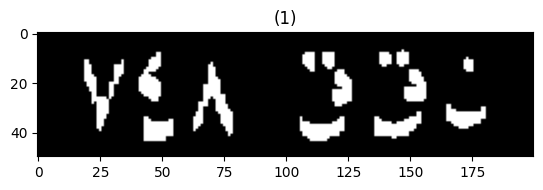

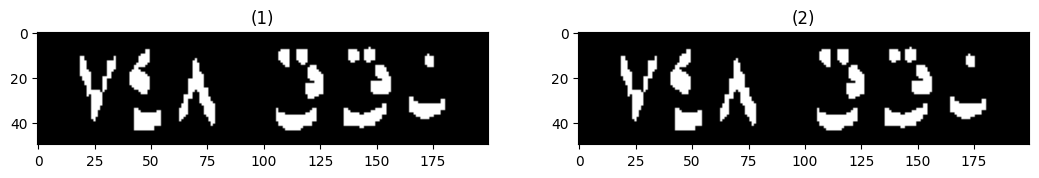

0.0035
area:11697.5
Ar:5.043478260869565


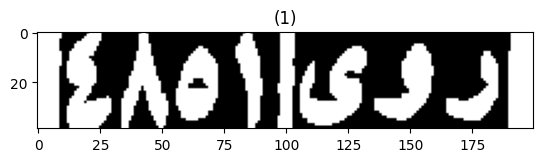

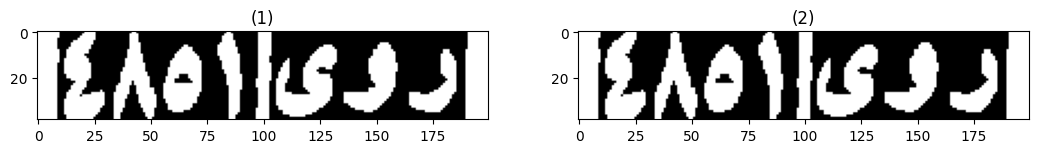

0.0031
area:9906.5
Ar:5.4


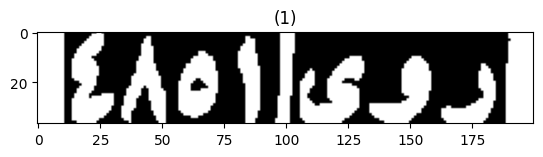

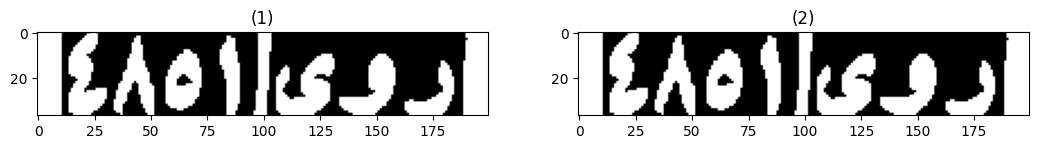

0.0062
area:5053.0
Ar:3.948717948717949


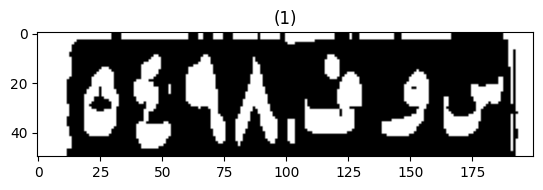

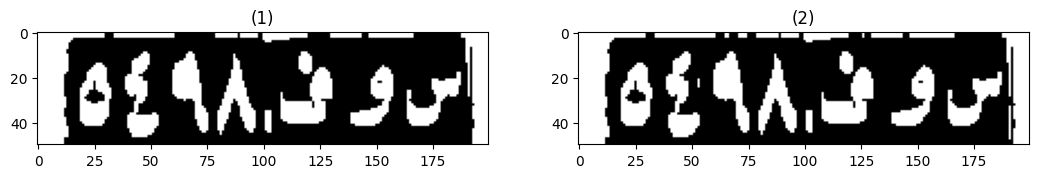

0.0058
area:6424.0
Ar:2.559322033898305


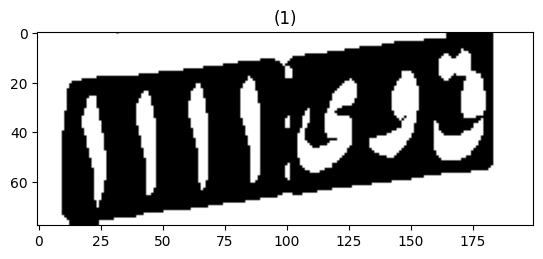

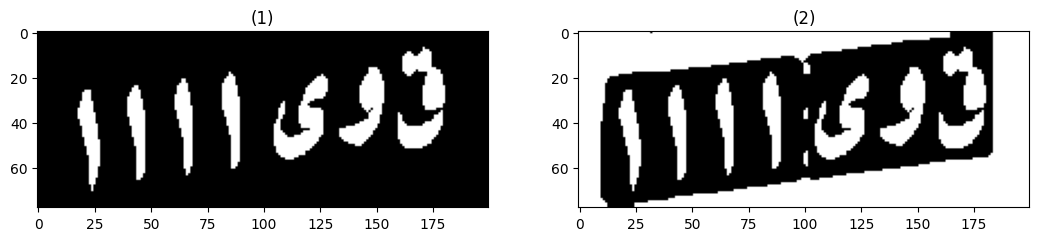

0.0013
area:6417.5
Ar:3.5217391304347827


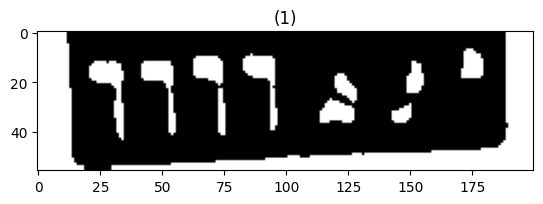

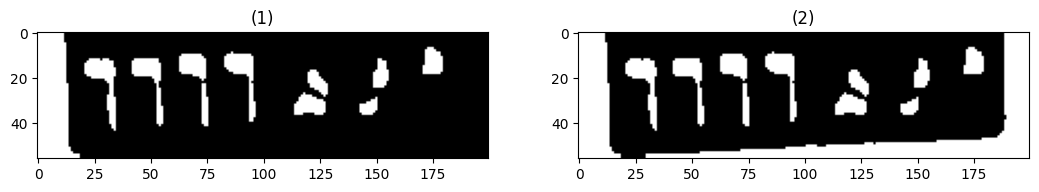

0.0009
area:5437.0
Ar:2.5925925925925926


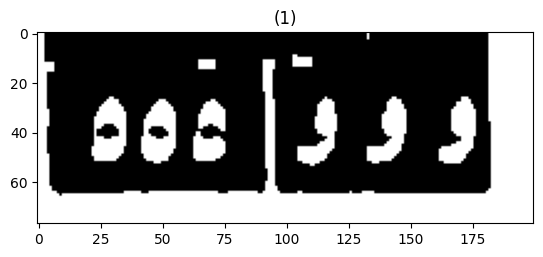

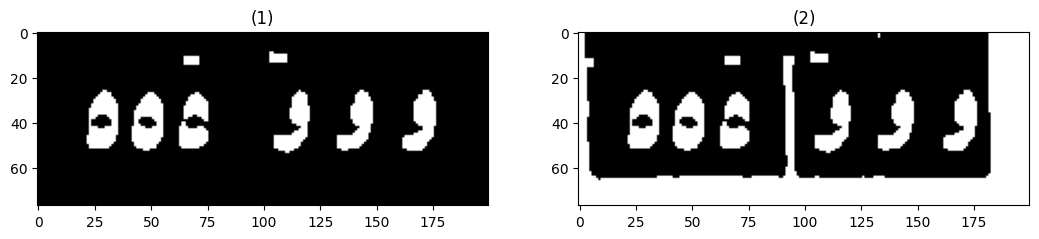

0.0052


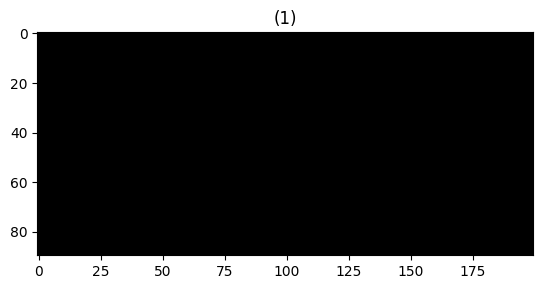

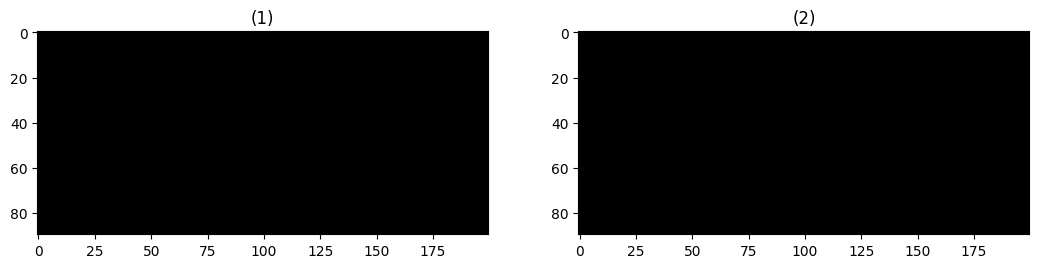

0.0015
area:10582.0
Ar:2.129032258064516


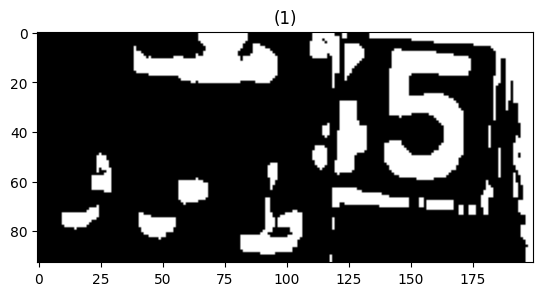

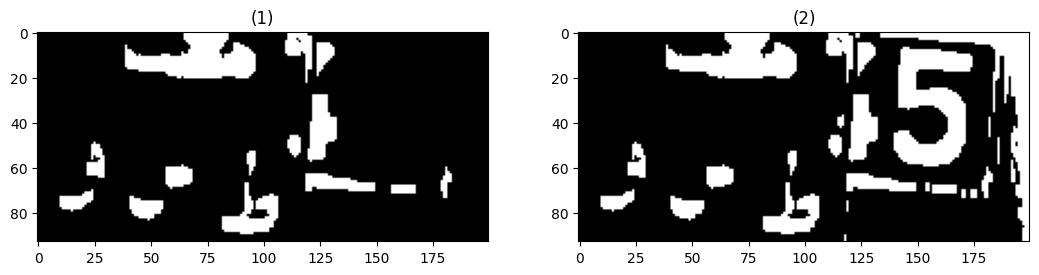

0.0256
****************************************************************************************************
area:5003.0
Ar:2.537037037037037


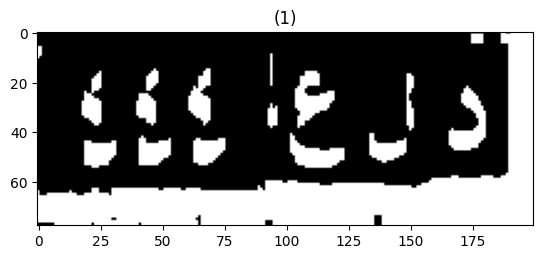

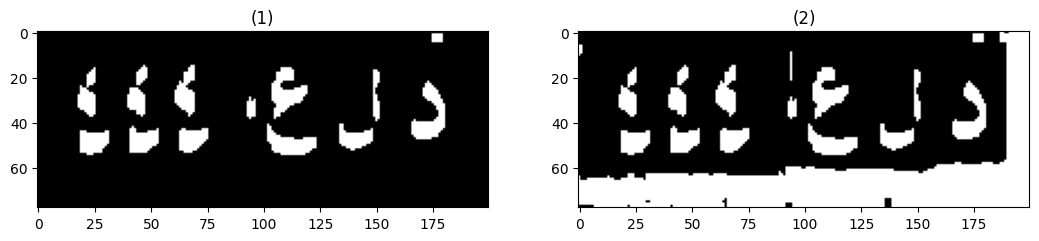

0.0017
area:9702.5
Ar:2.563380281690141


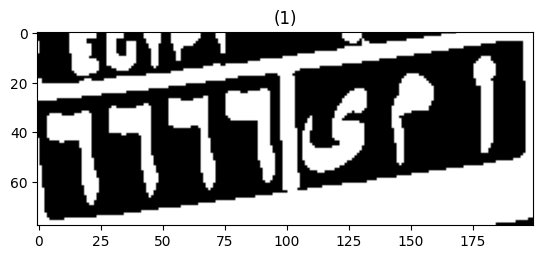

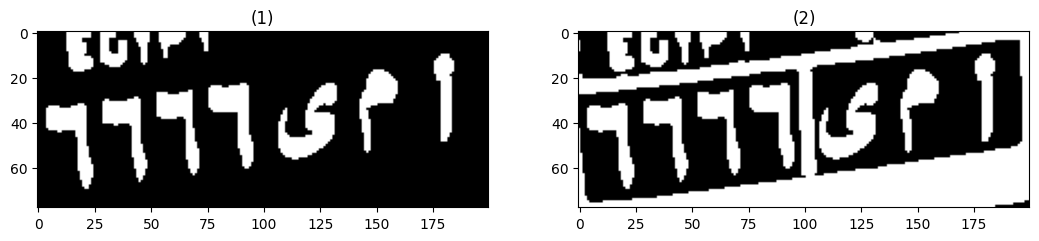

0.009
area:9351.0
Ar:3.230769230769231


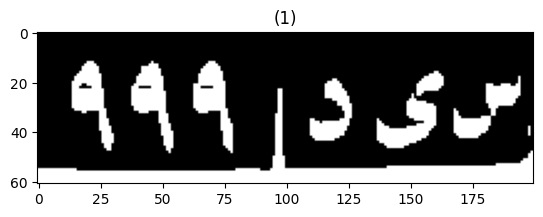

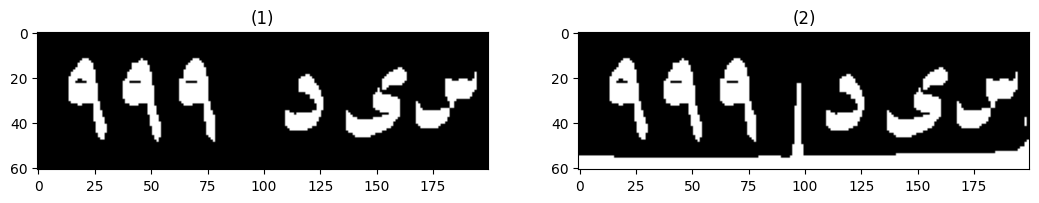

0.0048
area:8754.5
Ar:4.733333333333333


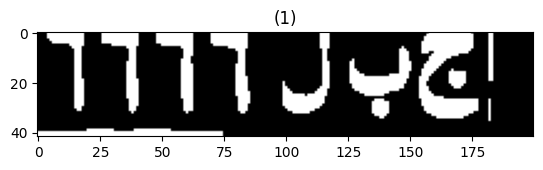

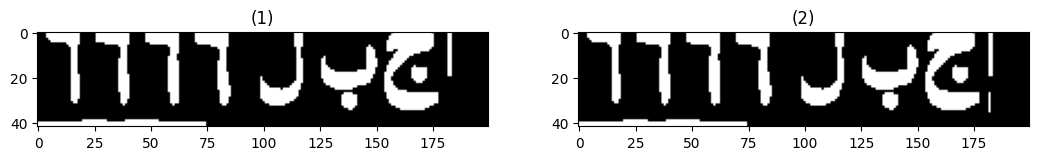

0.0076
area:3253.0
Ar:3.4864864864864864


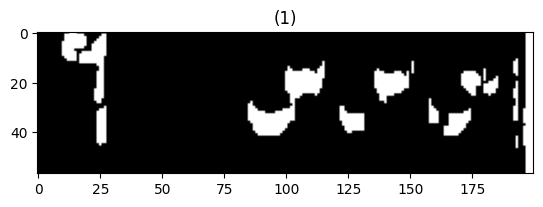

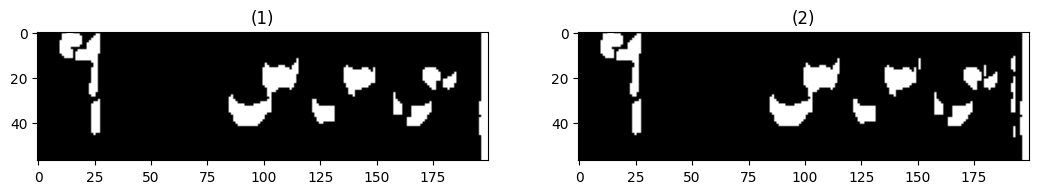

0.0026
area:7052.5
Ar:3.652173913043478


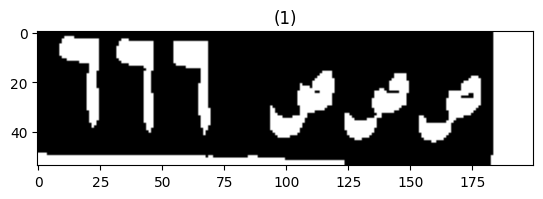

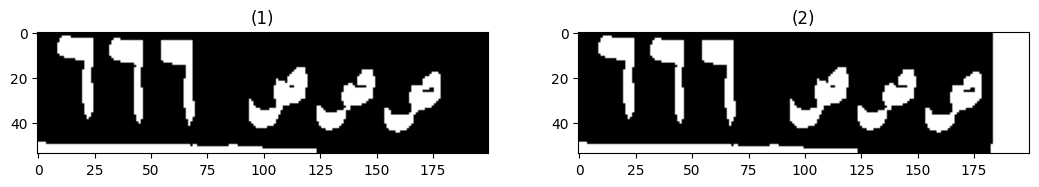

0.0034
area:3899.0


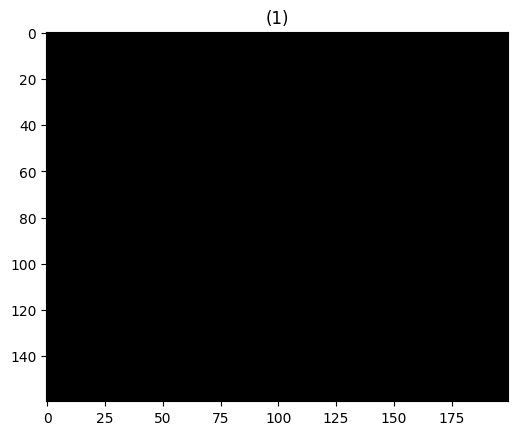

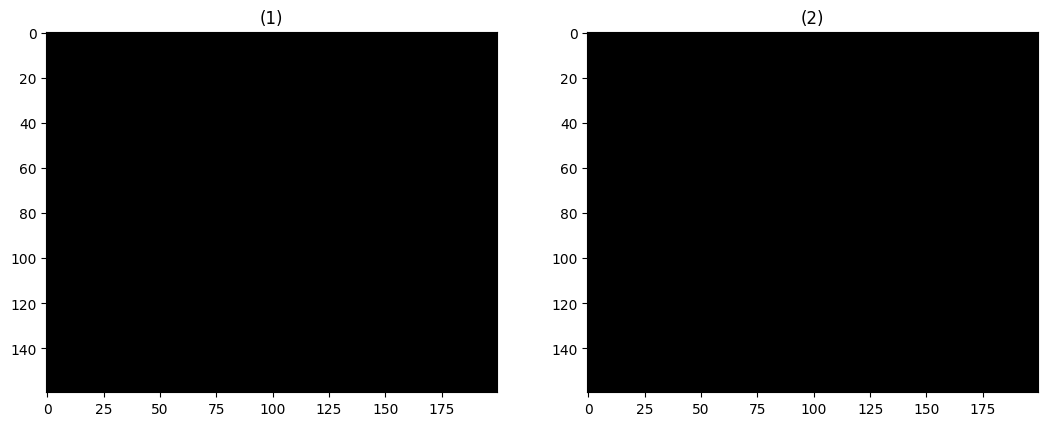

0.0033
area:10340.5
area:5724.0
area:5313.5
Ar:2.5


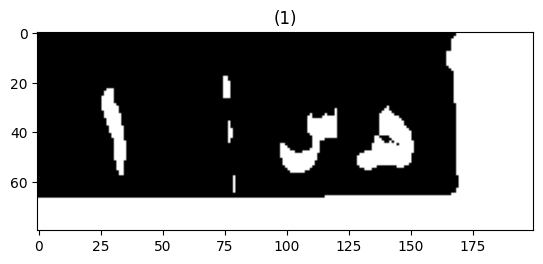

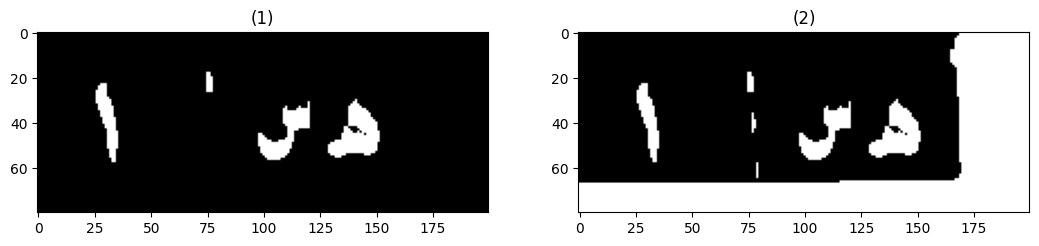

0.0052
area:8895.0
Ar:3.690909090909091


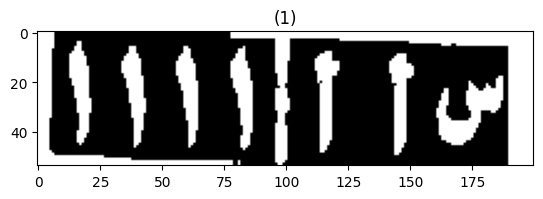

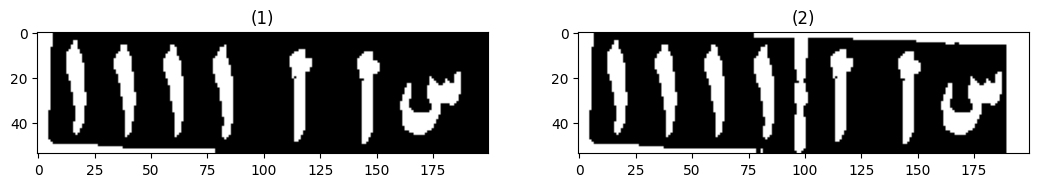

0.0029
area:9411.0
Ar:3.0142857142857142


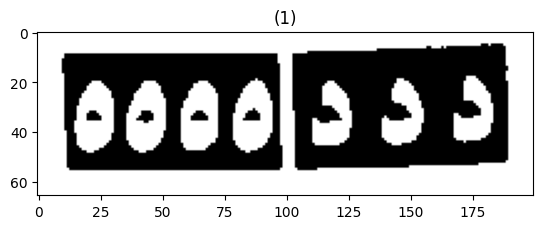

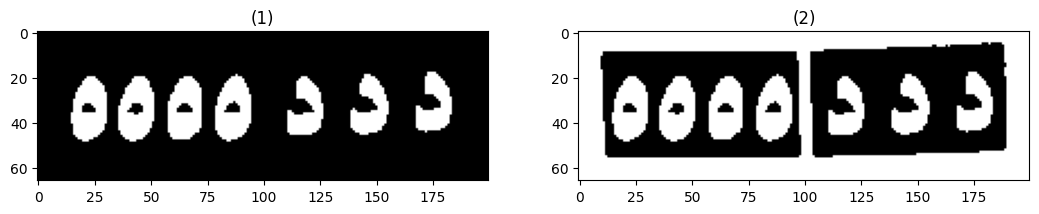

0.0024
area:13928.5
Ar:2.1363636363636362


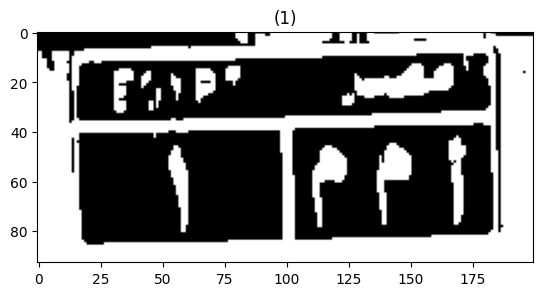

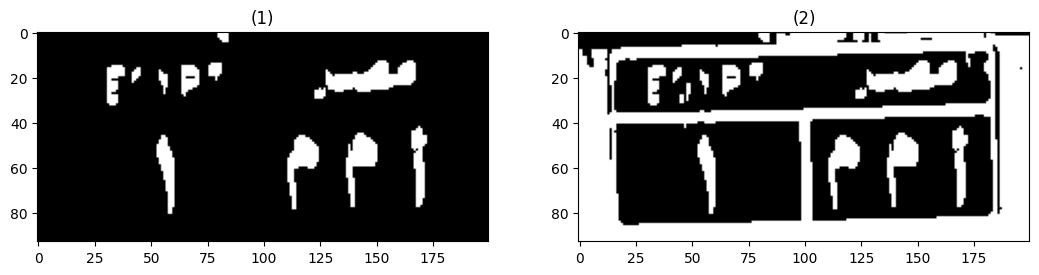

0.0066
area:3335.0
Ar:2.0


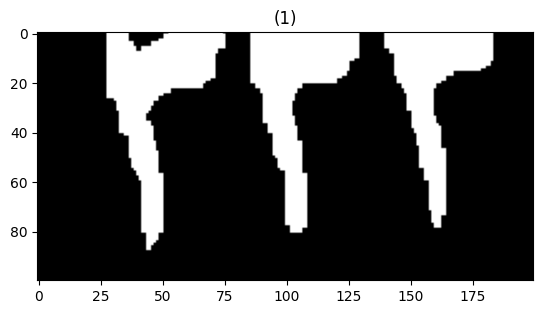

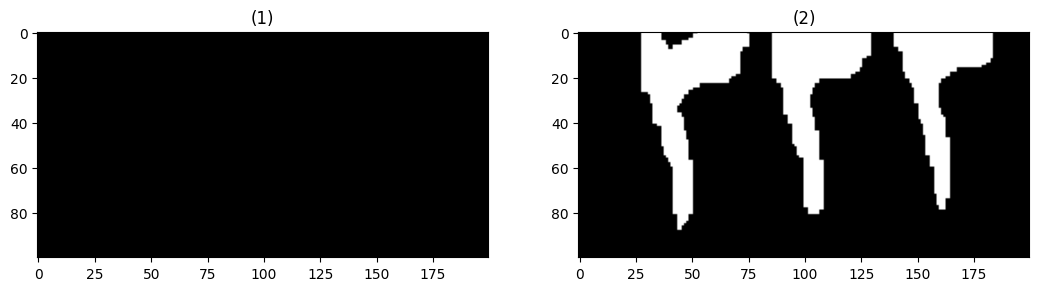

0.0173
****************************************************************************************************
area:5465.5
Ar:2.792452830188679


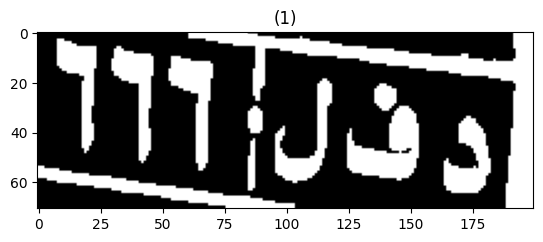

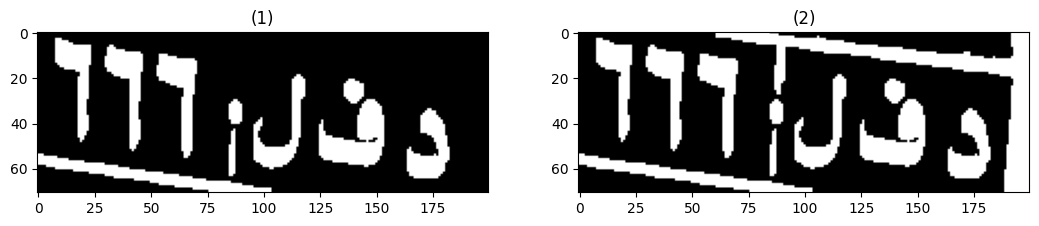

0.0035
area:12696.0
Ar:2.236559139784946


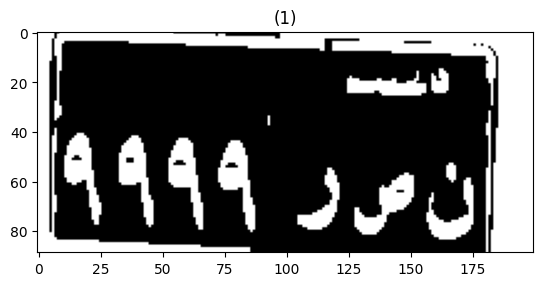

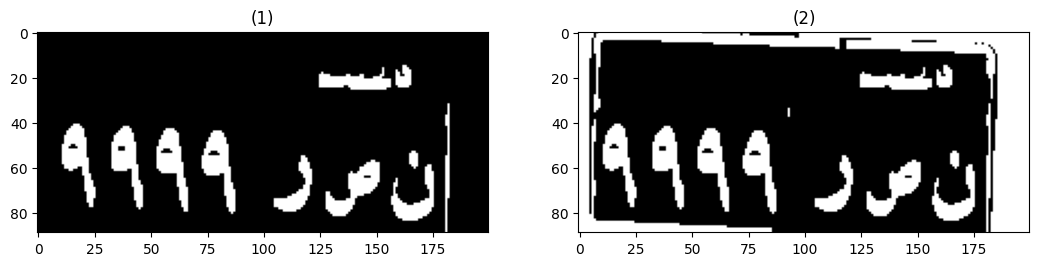

0.005
area:6498.0
Ar:1.9130434782608696


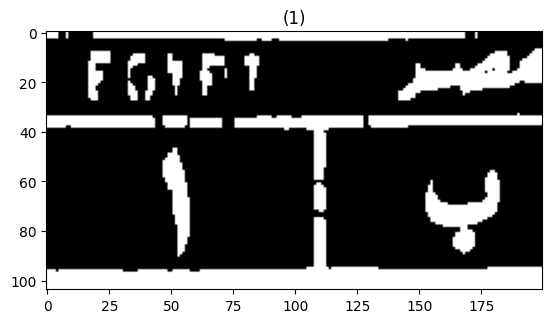

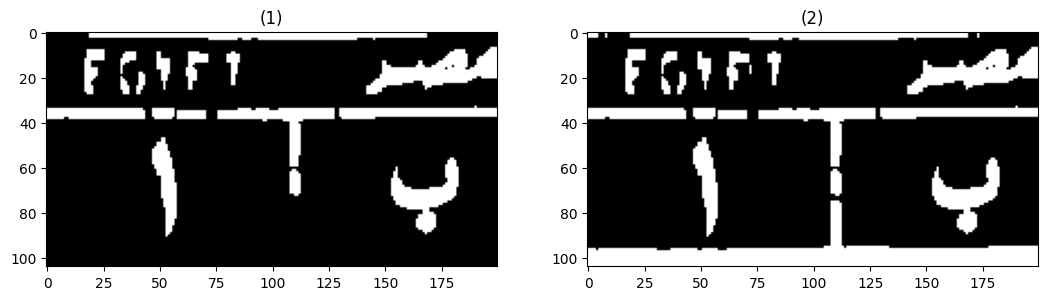

0.004
area:8456.5
Ar:2.918032786885246


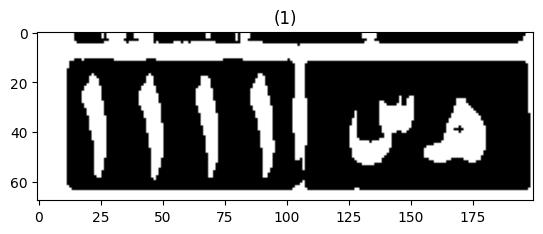

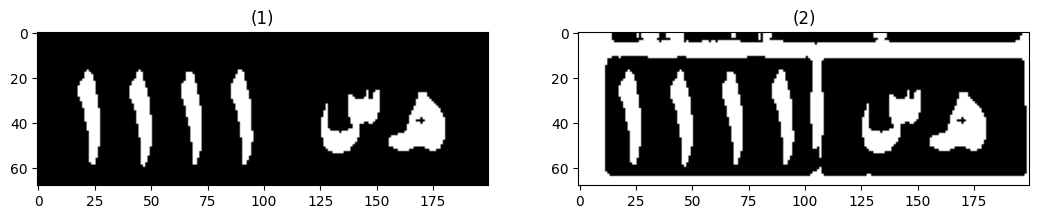

0.0051
area:7237.5
Ar:4.116279069767442


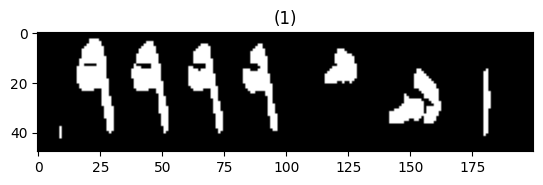

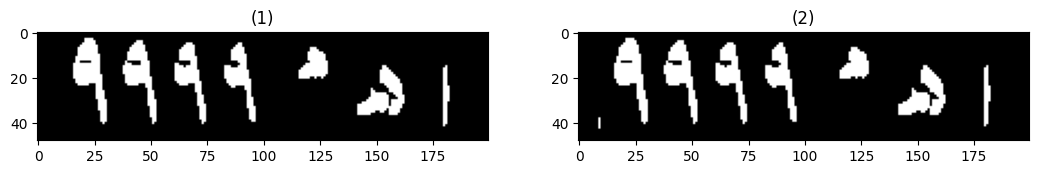

0.0042
area:11904.5
Ar:4.183333333333334


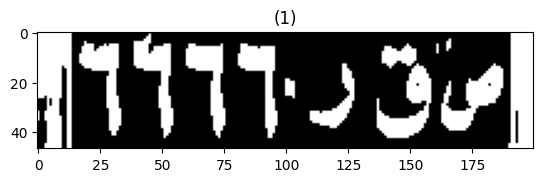

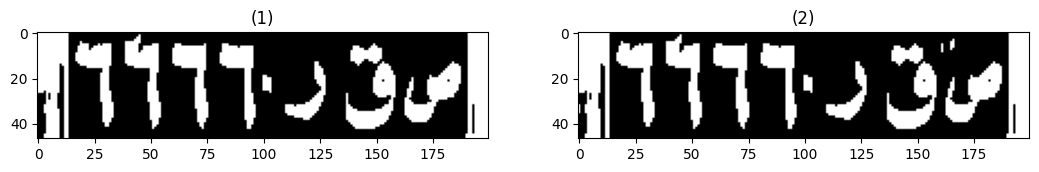

0.0036
area:3178.0
area:2206.5


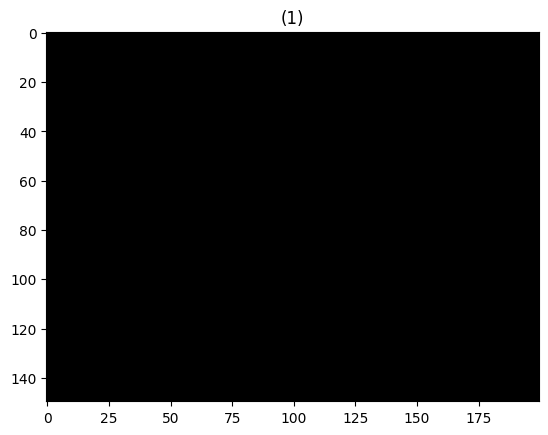

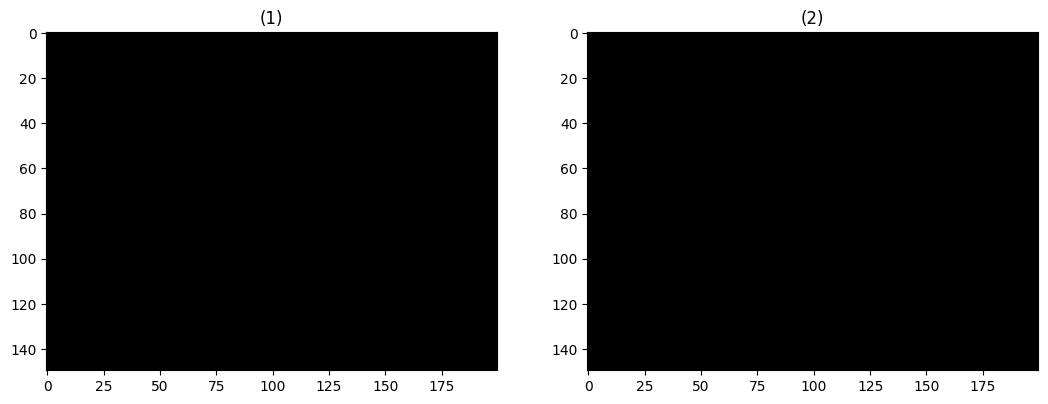

0.0066
area:7544.5
Ar:2.621212121212121


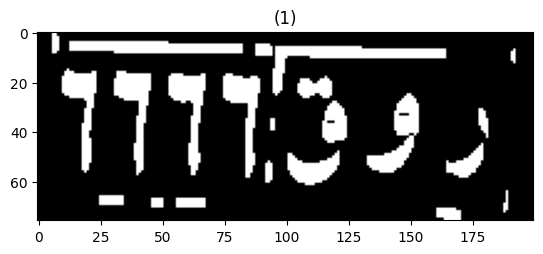

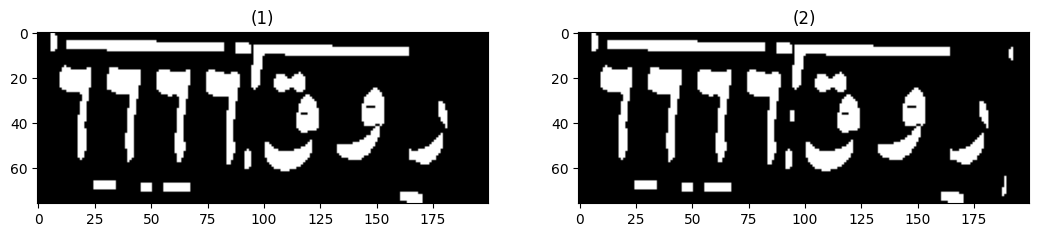

0.0031
area:15408.0
Ar:2.988235294117647


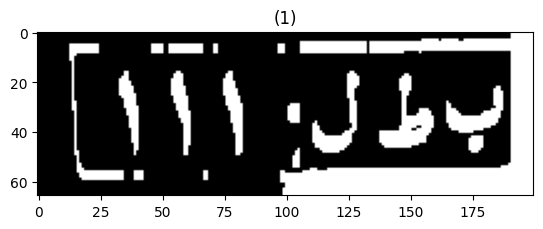

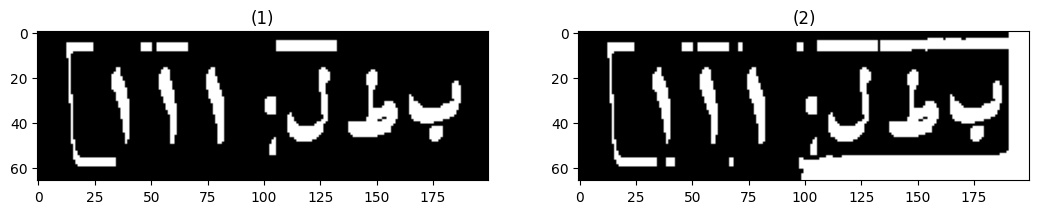

0.0058
area:6490.0
Ar:3.723404255319149


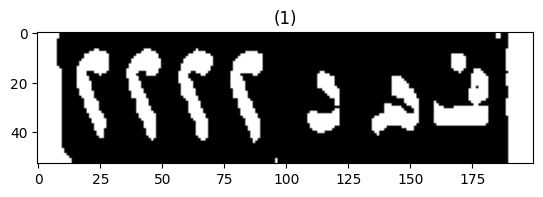

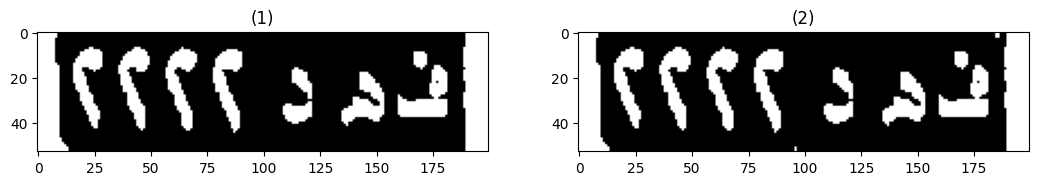

0.0089
area:8282.5
Ar:2.064935064935065


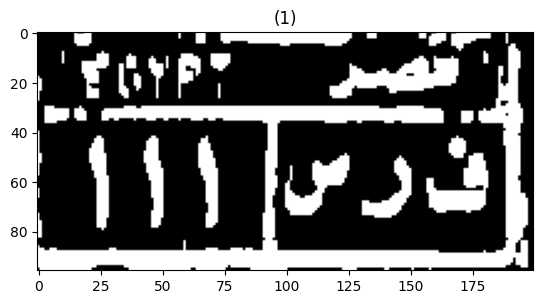

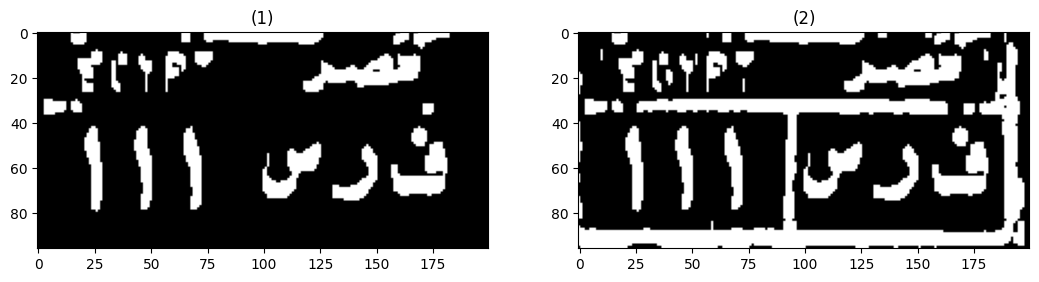

0.0067
area:10266.5
Ar:3.76271186440678


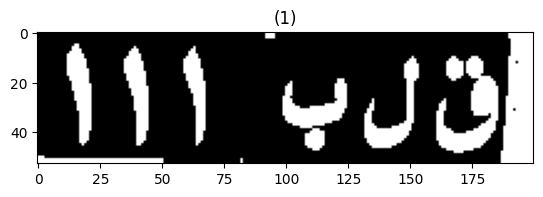

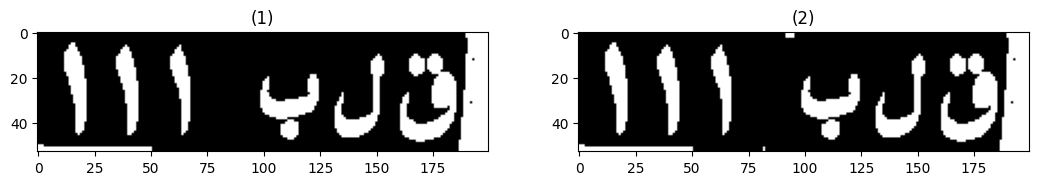

0.0113
****************************************************************************************************
area:9008.0
Ar:3.3333333333333335


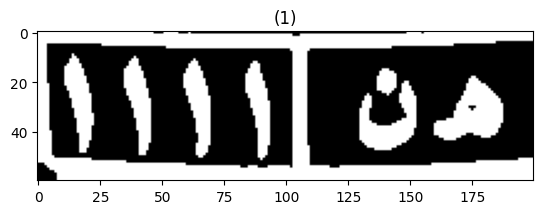

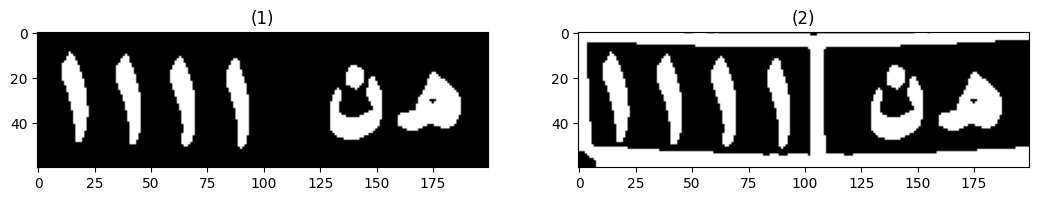

0.0041
area:10336.5
Ar:3.709090909090909


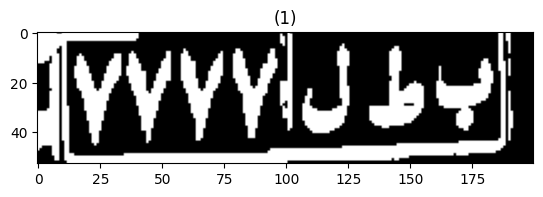

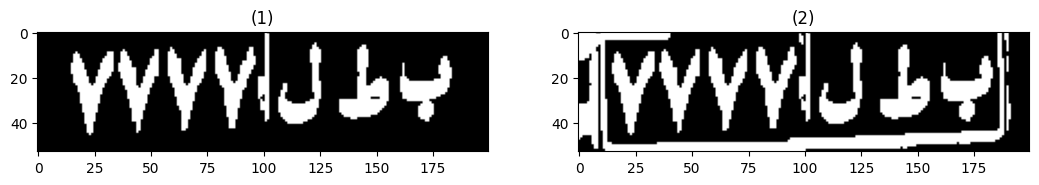

0.0049
area:12863.0
Ar:3.4246575342465753


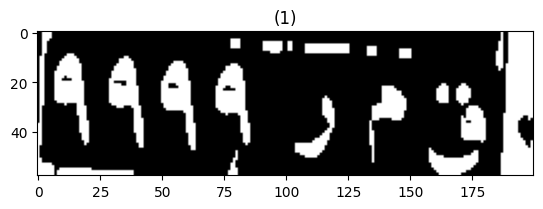

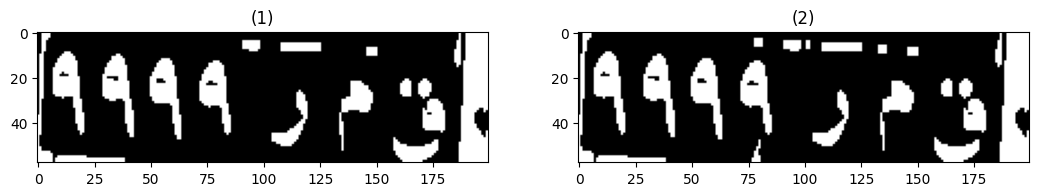

0.0092
area:4907.0
Ar:2.519230769230769


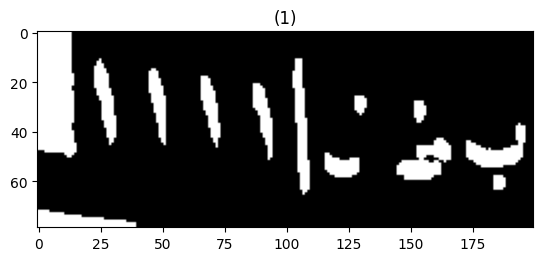

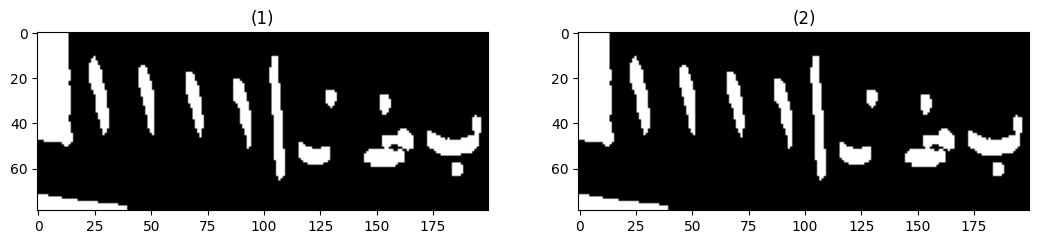

0.0035
area:7471.5
Ar:2.6666666666666665


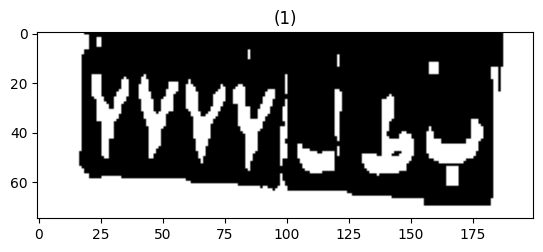

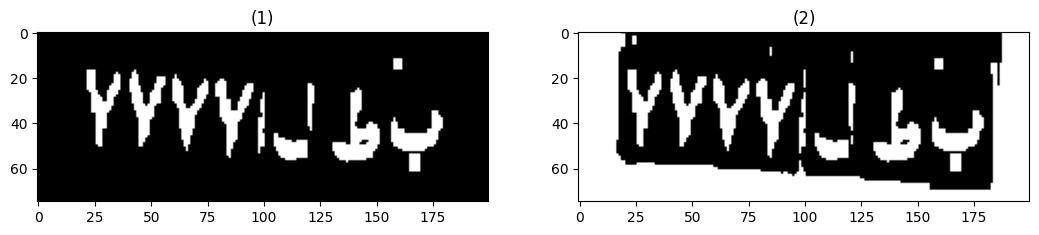

0.0052
area:7251.0
Ar:3.1147540983606556


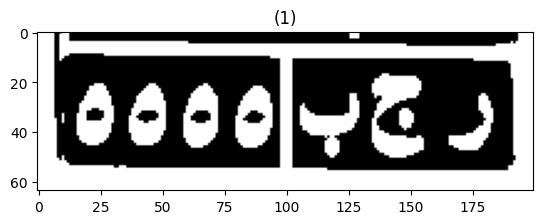

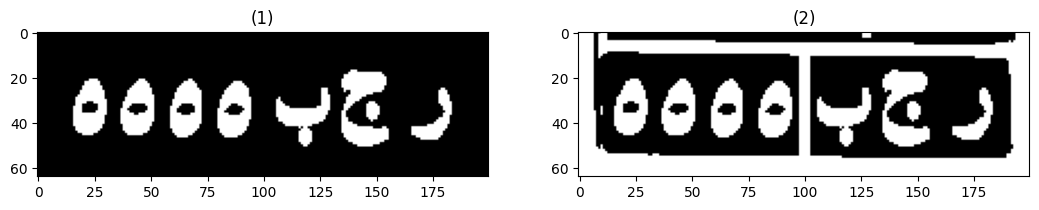

0.0084
area:9679.0
Ar:3.208955223880597


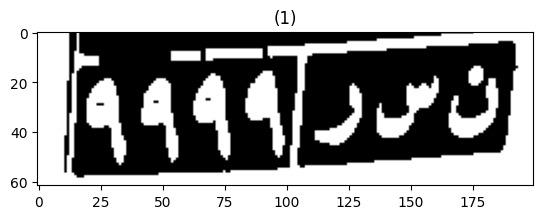

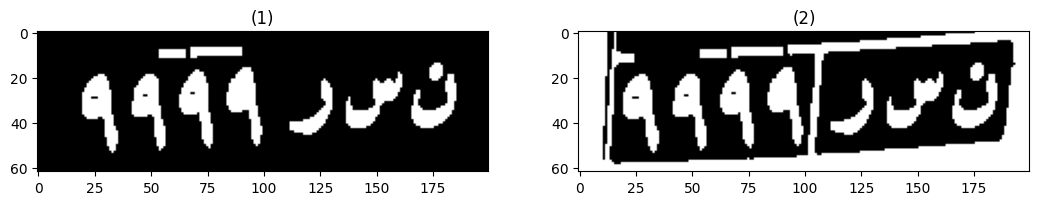

0.0094
area:12784.5
Ar:3.263157894736842


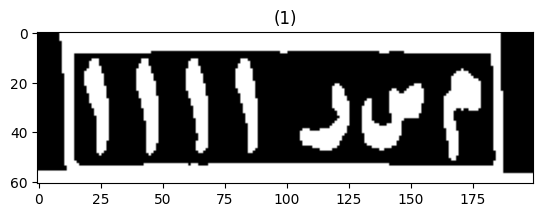

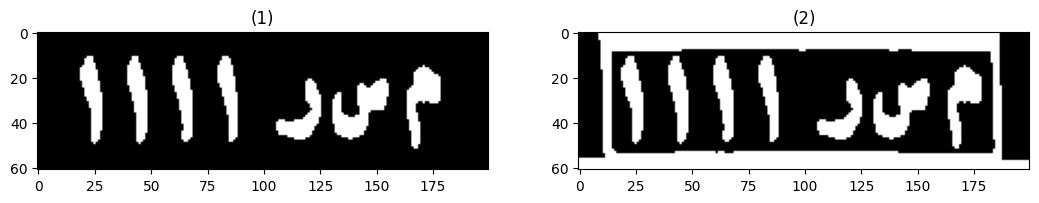

0.0117
****************************************************************************************************
area:6337.5
Ar:4.325


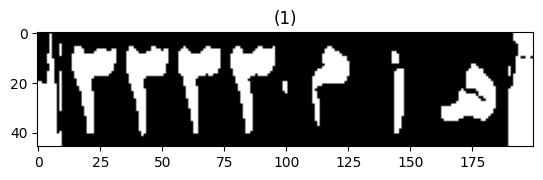

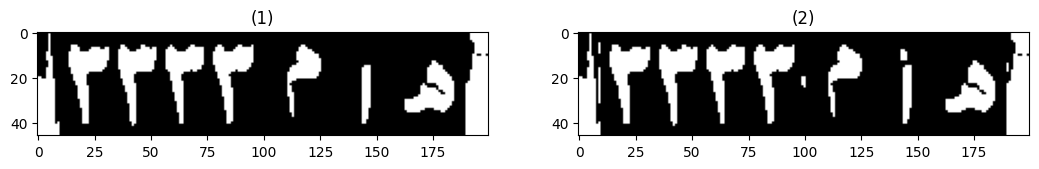

0.0044
area:6944.5
Ar:2.6


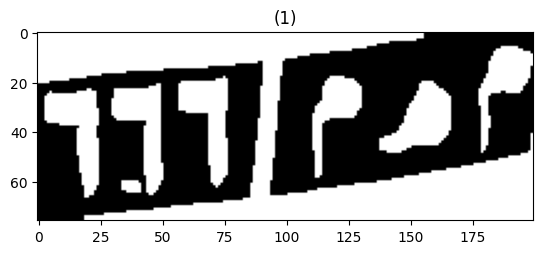

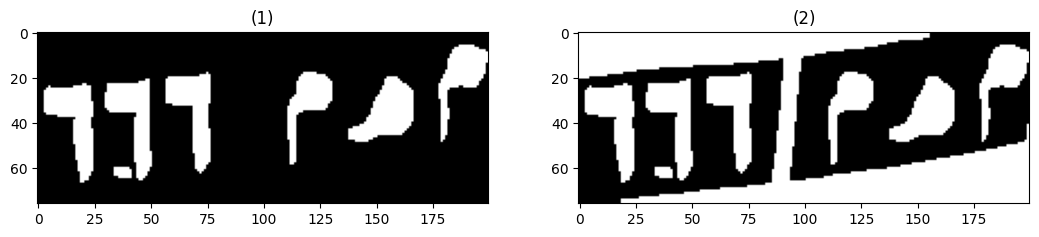

0.0032
area:12495.0
Ar:1.8347826086956522


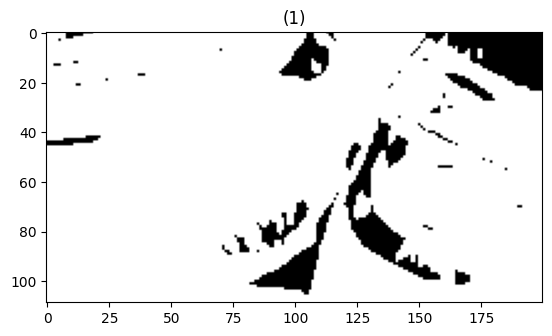

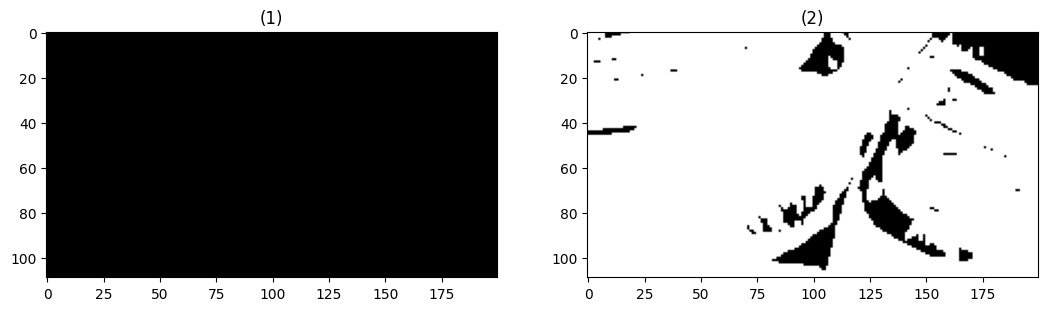

0.0039


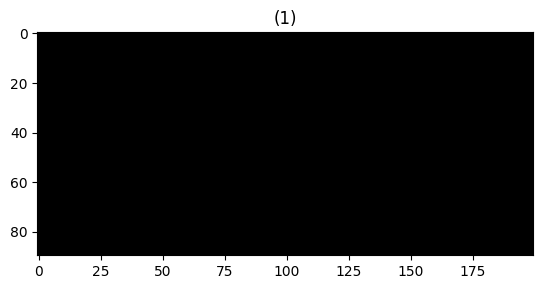

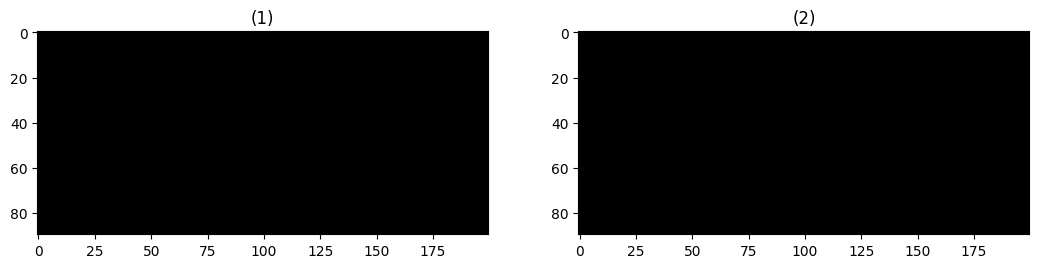

0.0029
area:8342.0
Ar:3.014925373134328


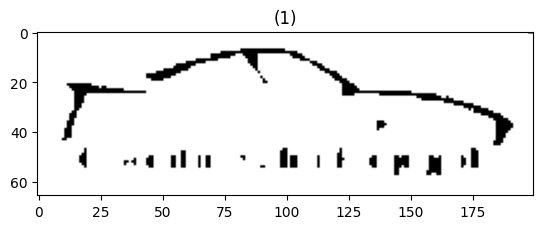

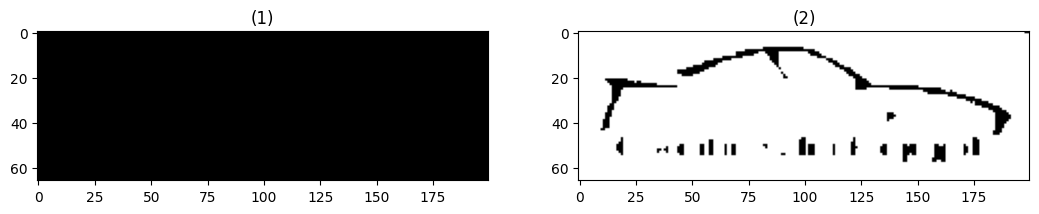

0.0037
area:7388.5
Ar:2.1447368421052633


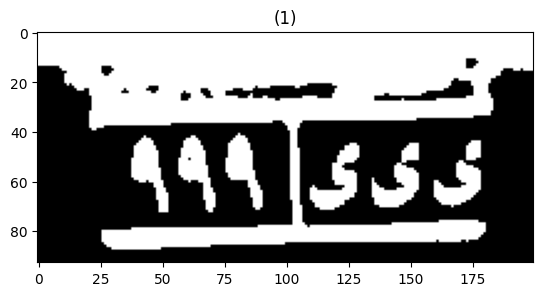

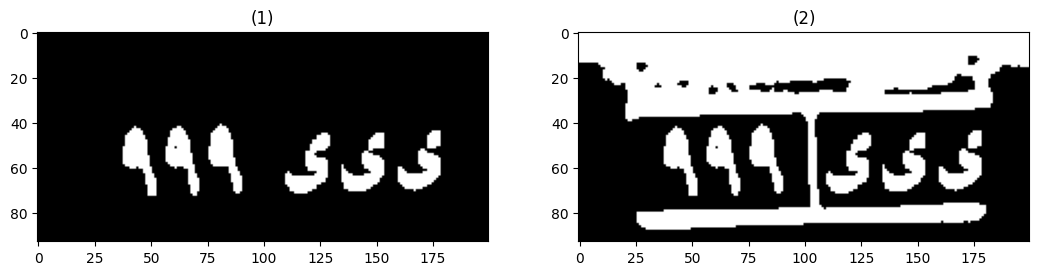

0.0063
area:4280.5
area:3597.0
Ar:4.5


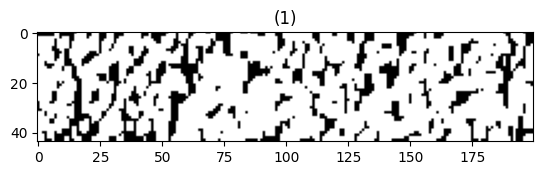

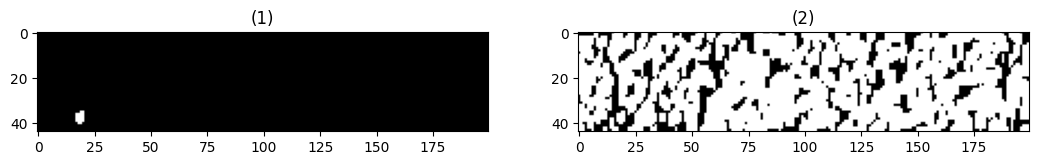

0.0027
area:13756.0
area:5102.5
Ar:3.341463414634146


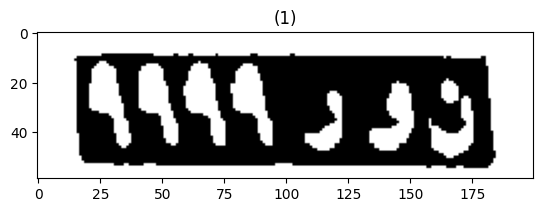

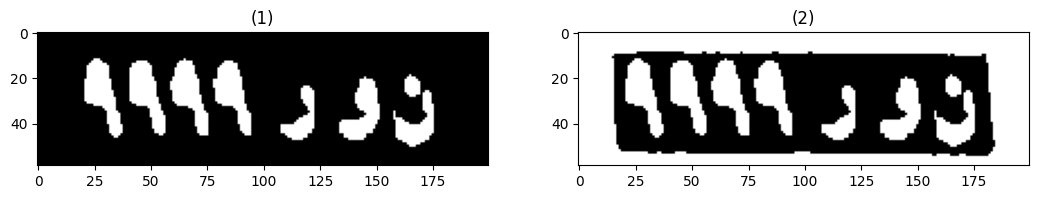

0.0018
area:9729.0
Ar:3.015625


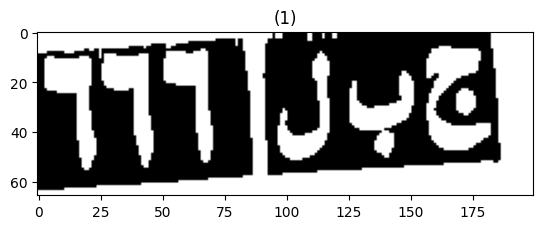

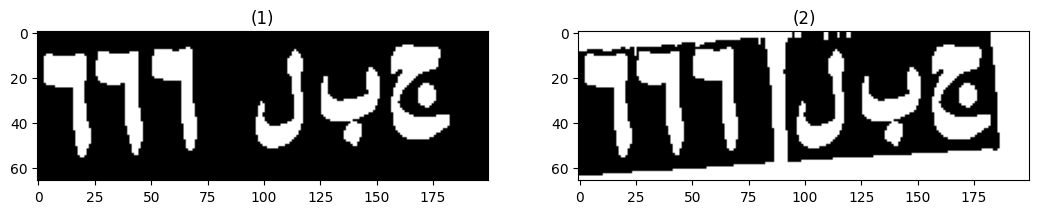

0.0036
area:10472.5
Ar:3.1176470588235294


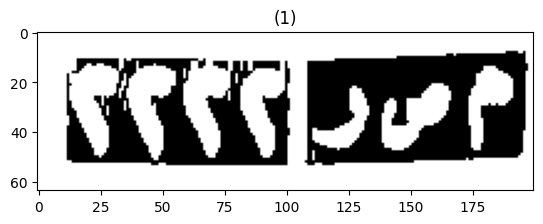

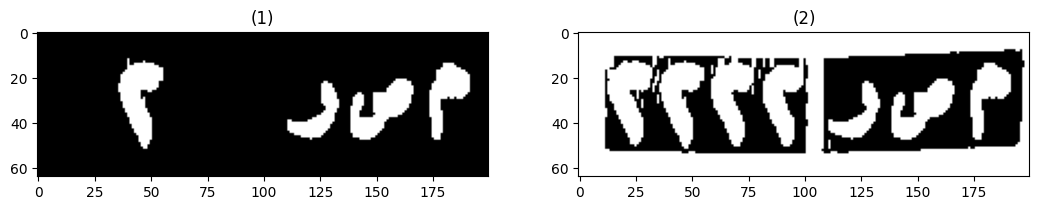

0.0066
area:6954.0
Ar:2.8833333333333333


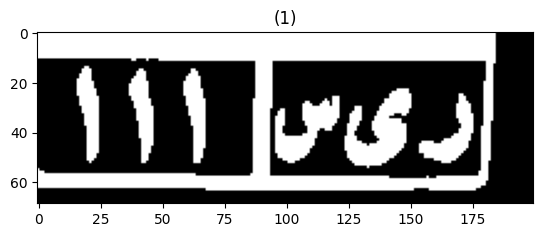

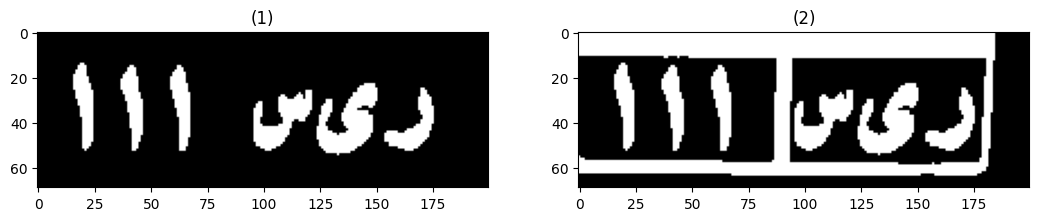

0.0033
area:6964.0
Ar:3.358490566037736


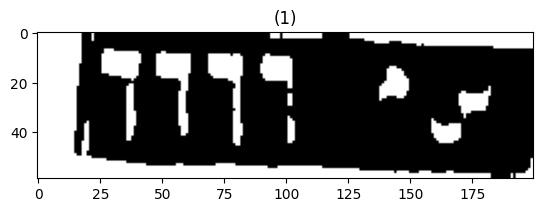

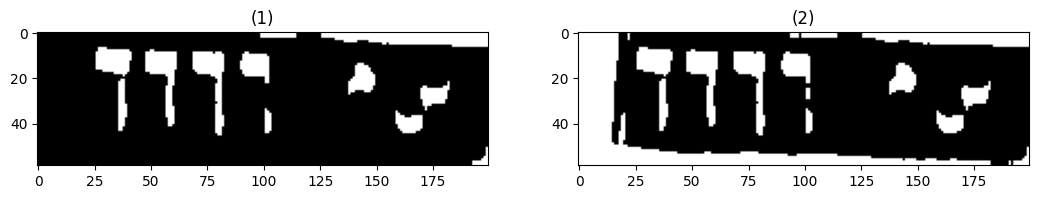

0.0023
area:15757.0
Ar:2.4766355140186915


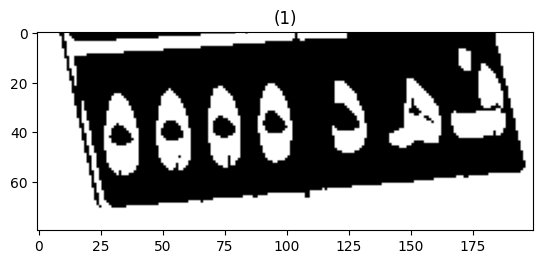

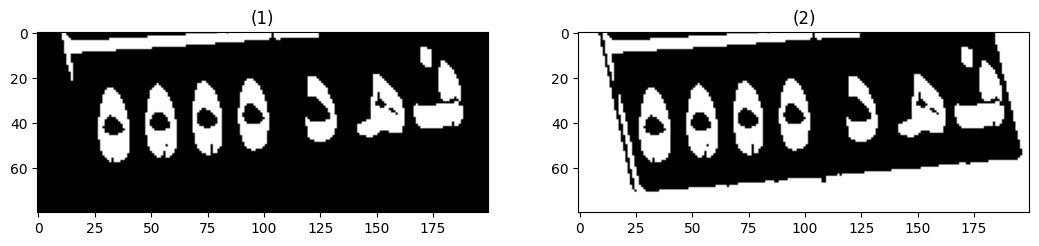

0.0018
area:8656.5
Ar:2.626865671641791


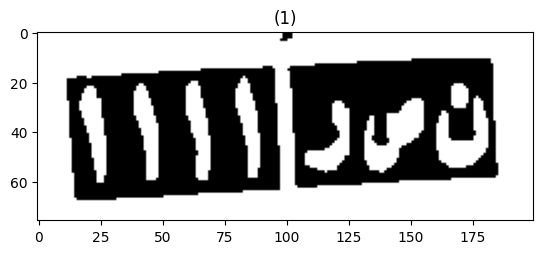

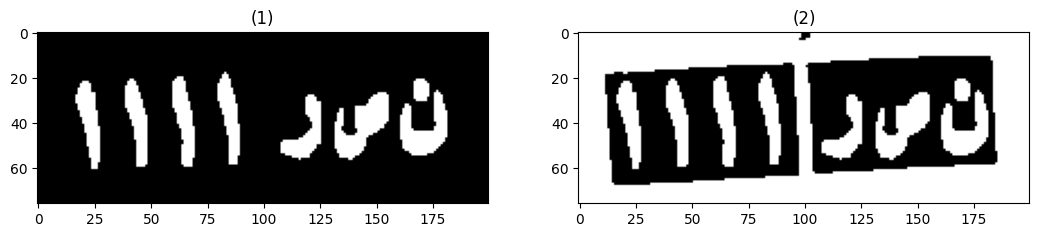

0.0029
area:7788.0
area:7404.0
Ar:2.909090909090909


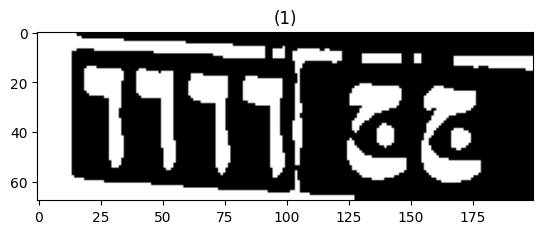

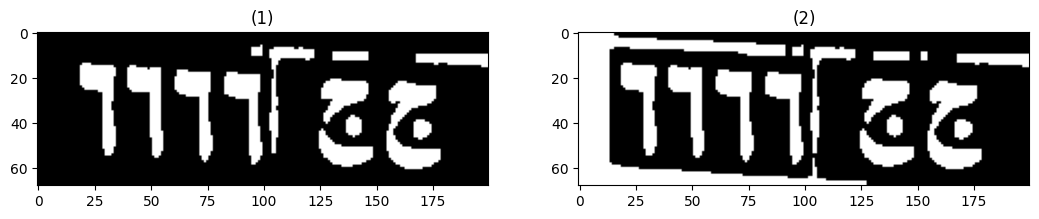

0.0052
area:12269.0
Ar:3.3333333333333335


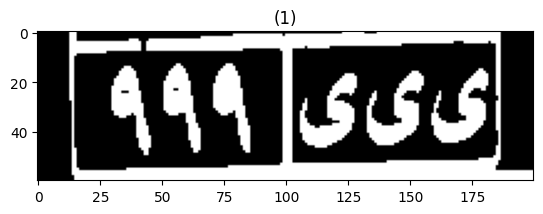

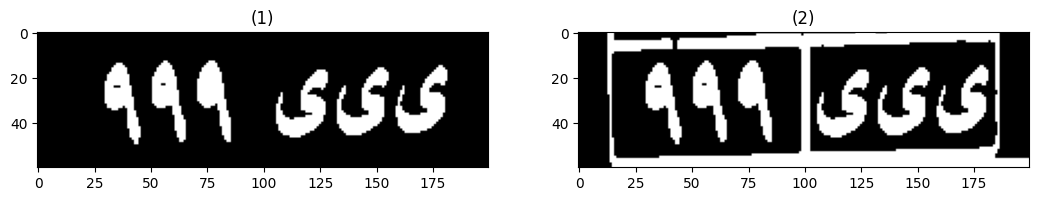

0.0101
****************************************************************************************************
area:8413.5
Ar:3.890909090909091


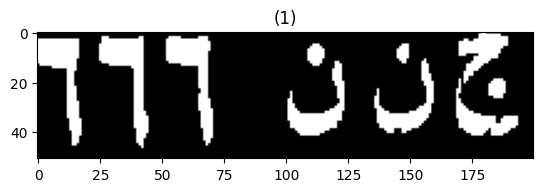

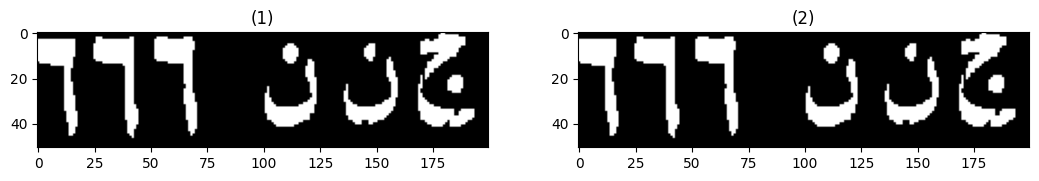

0.0009
area:5319.0
Ar:3.975609756097561


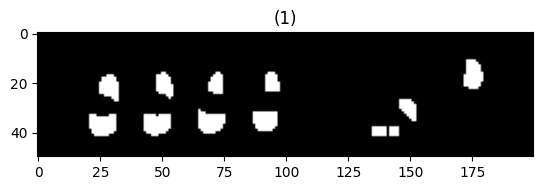

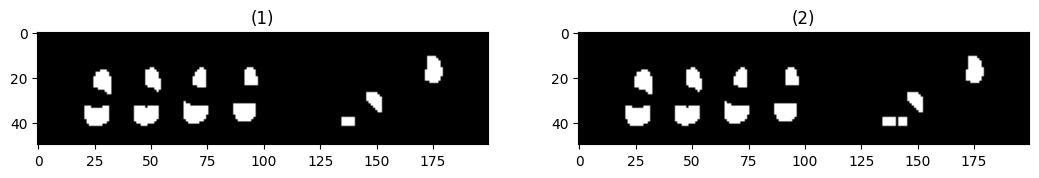

0.0045
area:4999.0
Ar:2.588235294117647


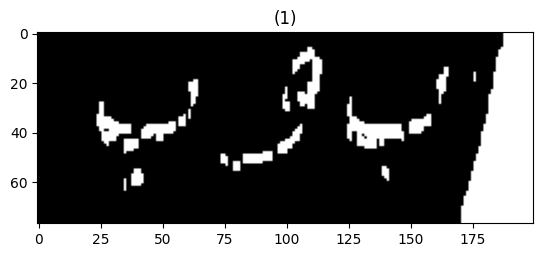

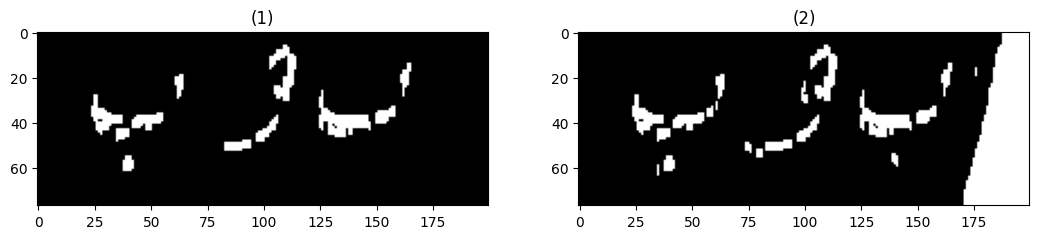

0.0061
area:9449.0
Ar:3.216666666666667


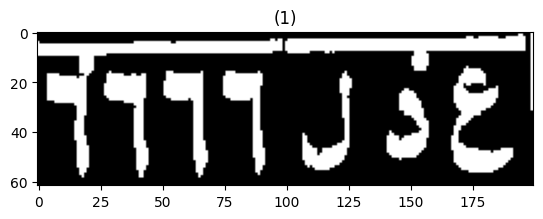

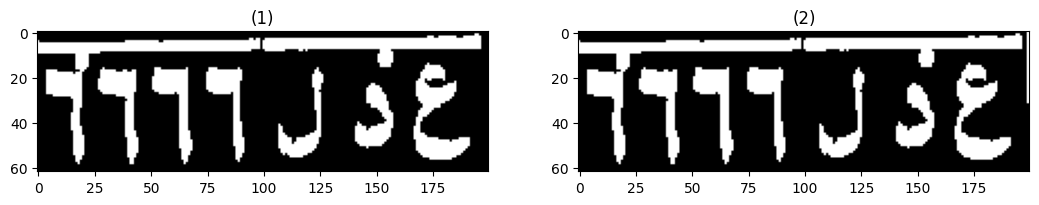

0.0118
****************************************************************************************************
area:13555.0
Ar:1.8725490196078431


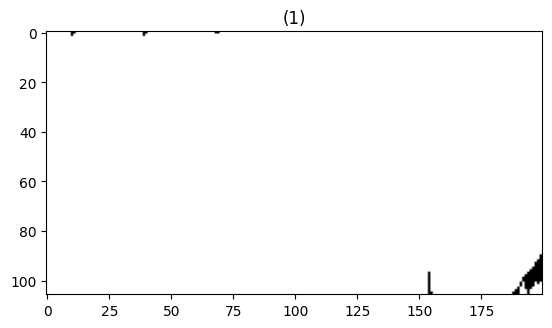

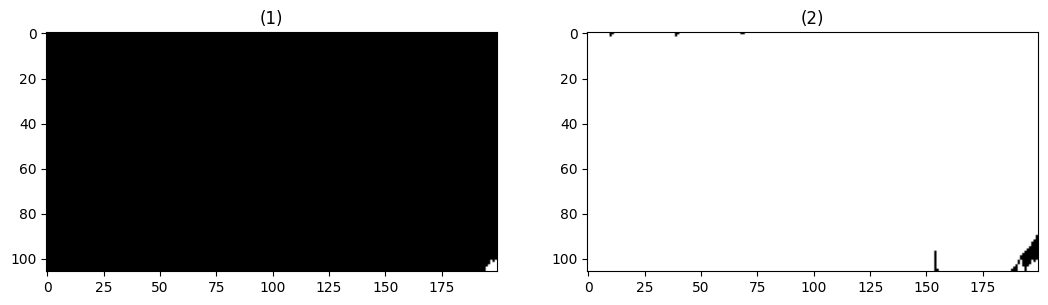

0.0062
area:6653.5
Ar:3.1320754716981134


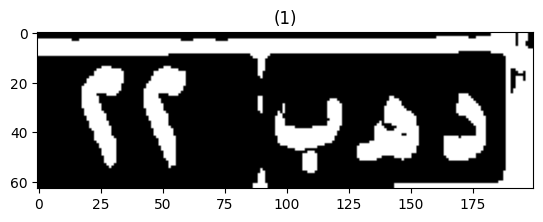

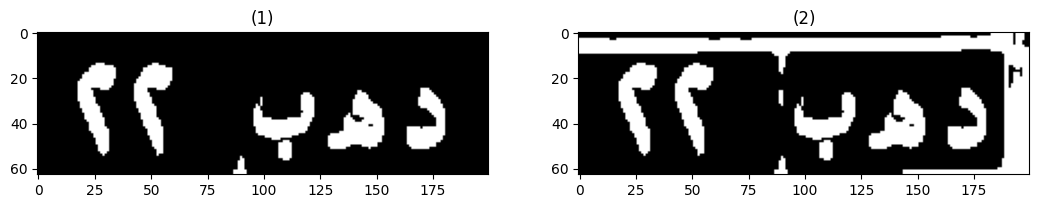

0.0031
area:6593.0
Ar:3.4375


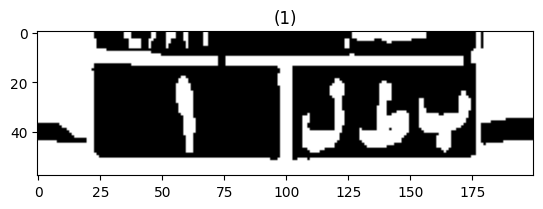

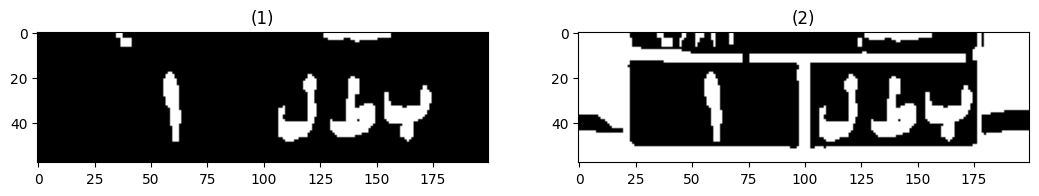

0.0019
area:7062.5
area:5926.5
Ar:2.9215686274509802


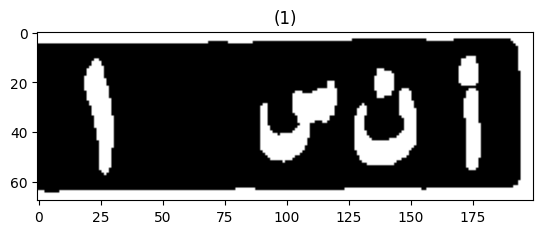

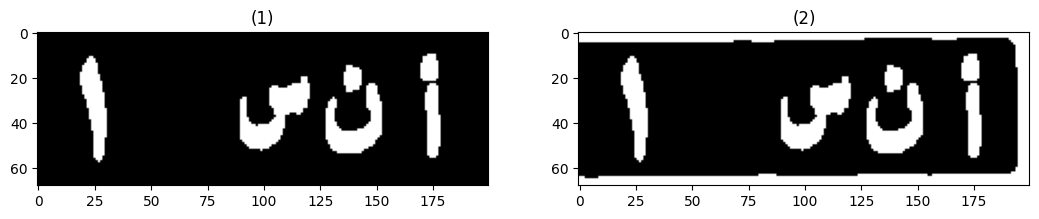

0.0021
area:10538.5
Ar:3.7066666666666666


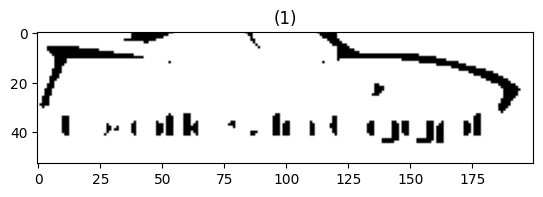

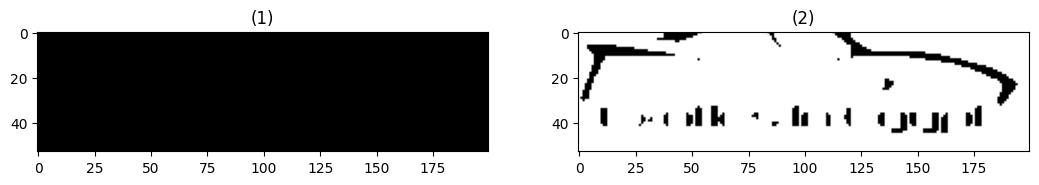

0.0066
area:6194.5
Ar:3.9285714285714284


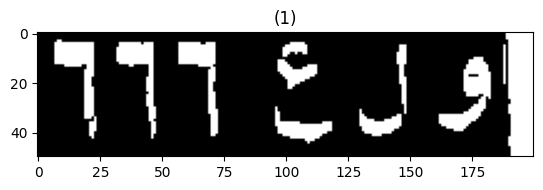

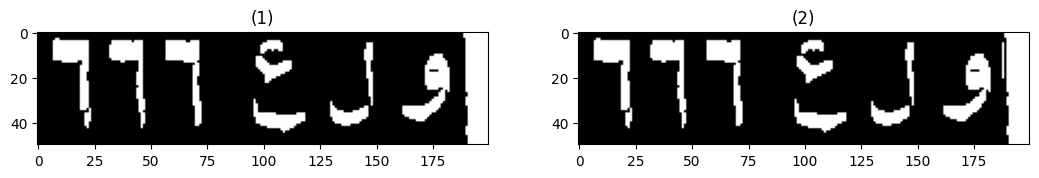

0.007
area:8767.0
Ar:4.75


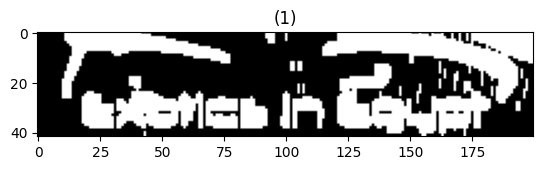

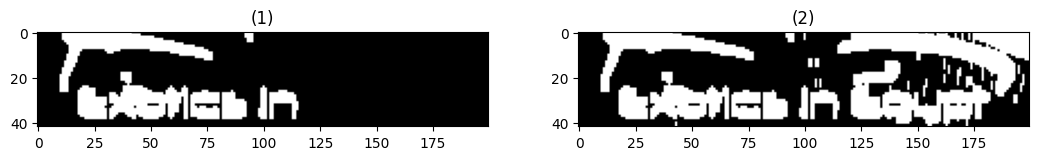

0.007
area:7928.5
Ar:2.935483870967742


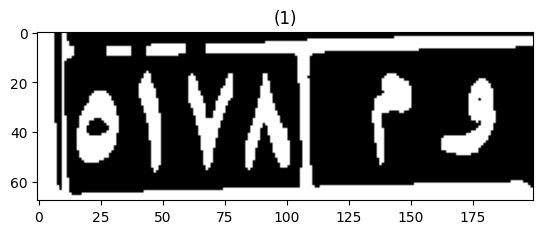

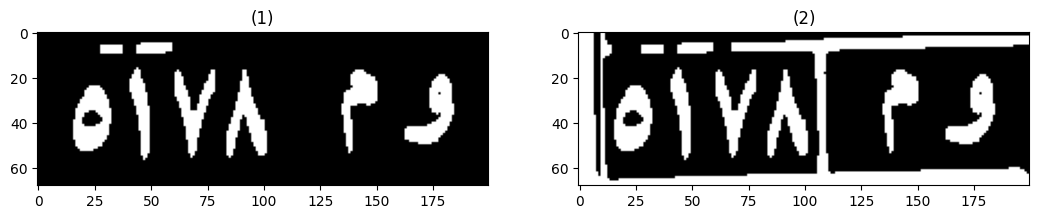

0.0023
area:5252.0
Ar:3.2142857142857144


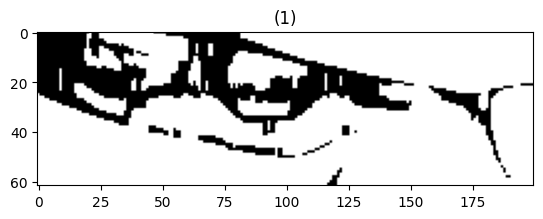

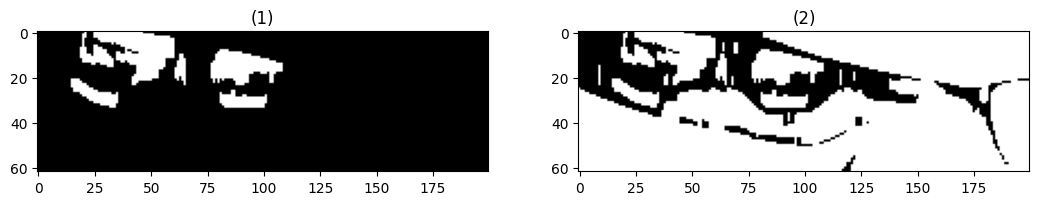

0.0012
area:6771.0
Ar:2.1470588235294117


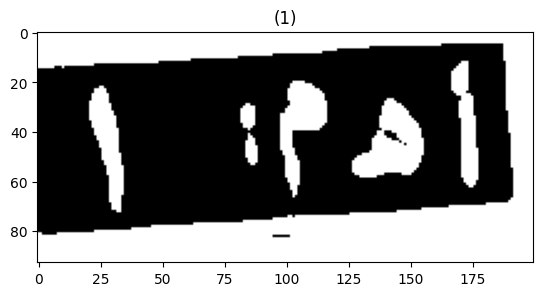

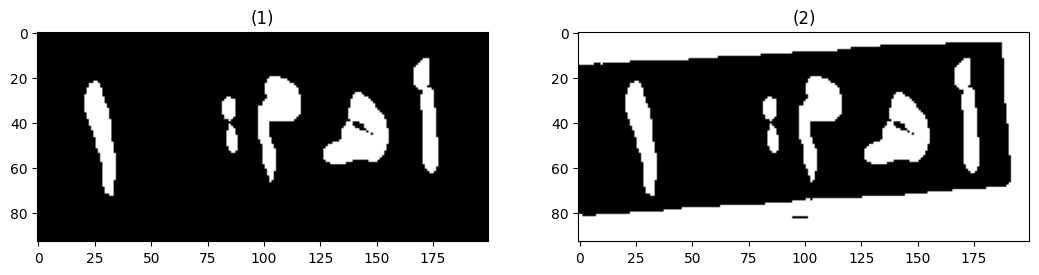

0.0043
area:4779.0
Ar:2.9791666666666665


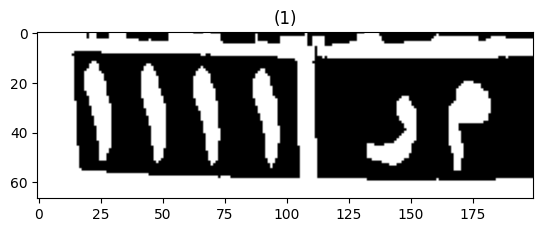

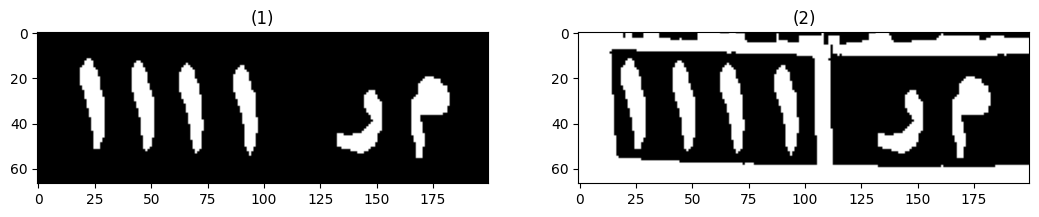

0.0024


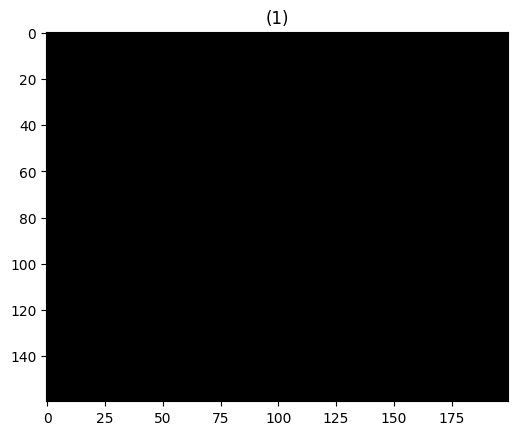

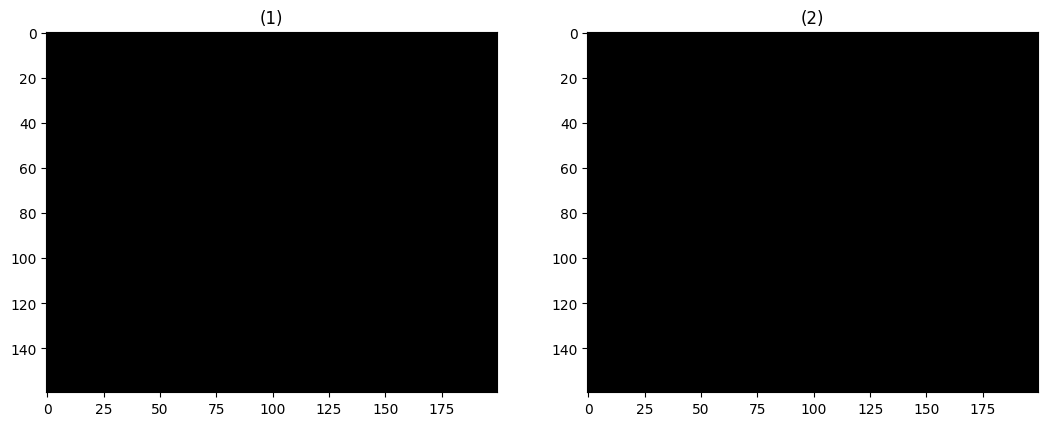

0.0049
area:7281.5
Ar:3.8085106382978724


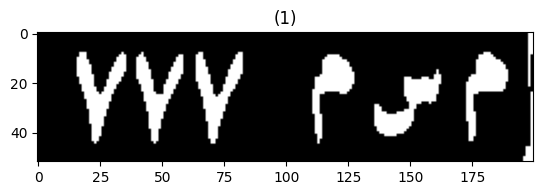

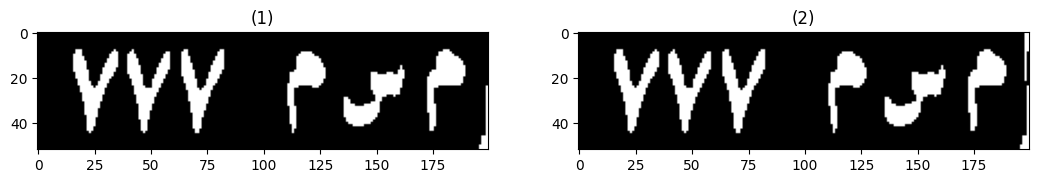

0.0058
area:5948.5
Ar:3.8


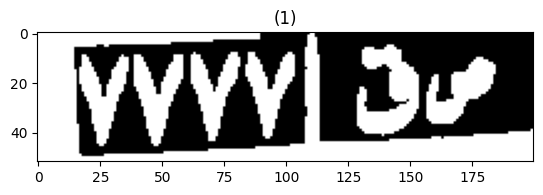

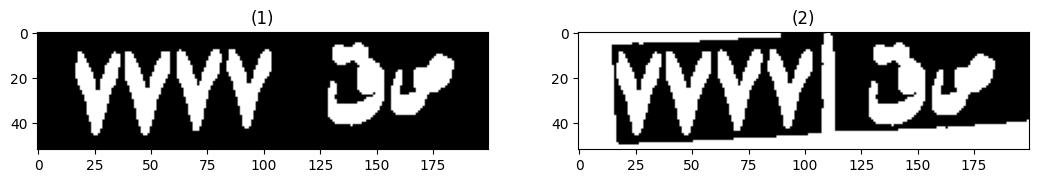

0.0026
area:4953.0
area:4226.5
Ar:3.2045454545454546


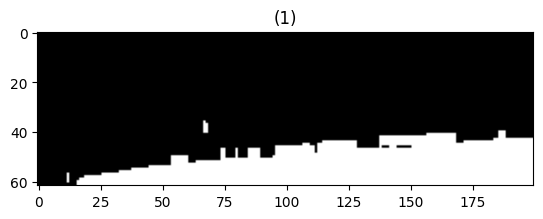

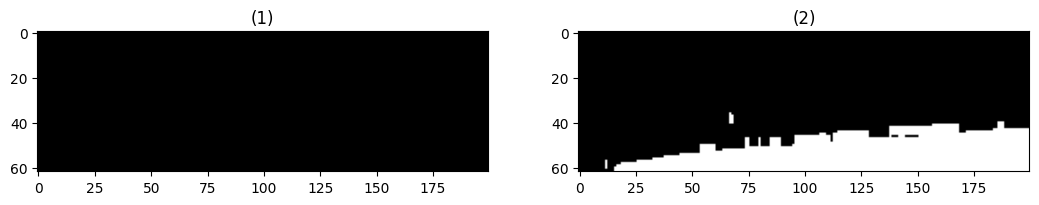

0.0025
area:7308.5
Ar:2.5555555555555554


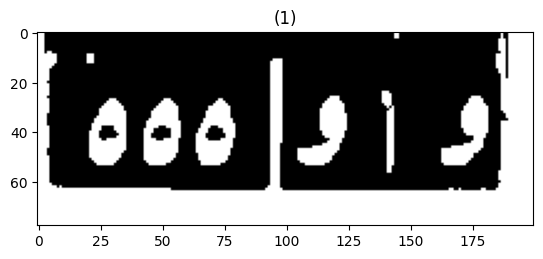

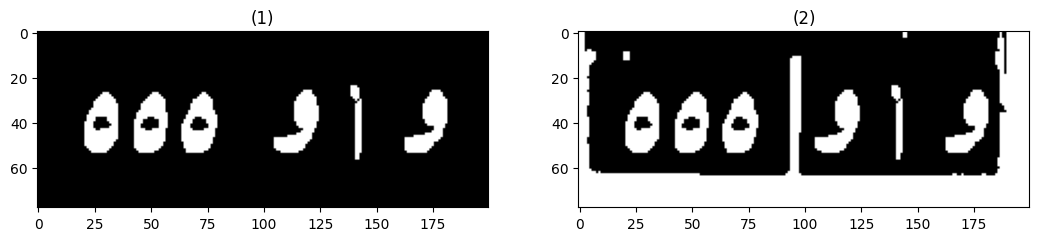

0.0036
area:17240.5
Ar:2.1031746031746033


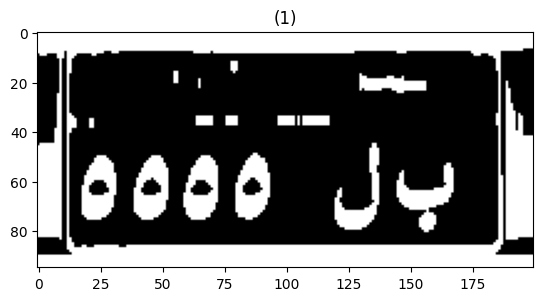

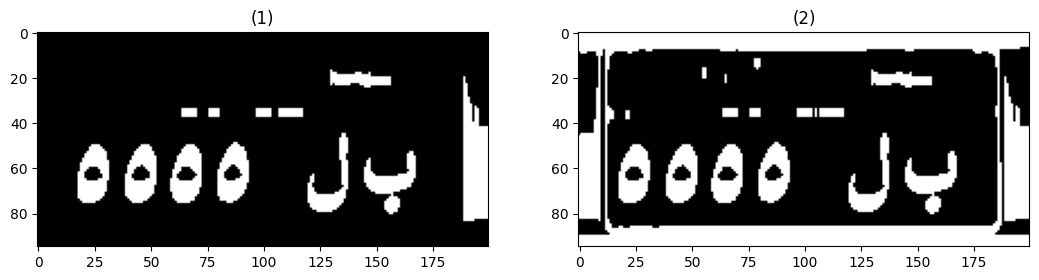

0.0015
area:5997.5
Ar:2.293103448275862


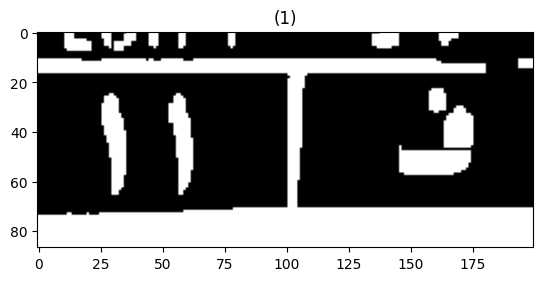

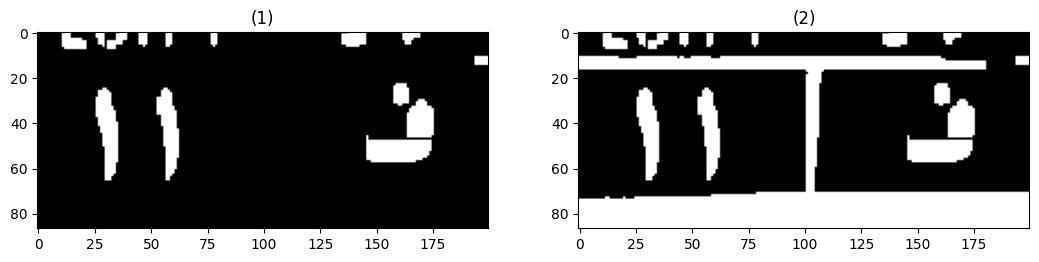

0.0059
area:4884.5
Ar:4.194444444444445


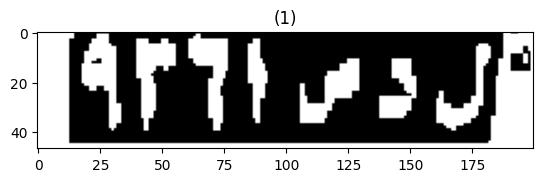

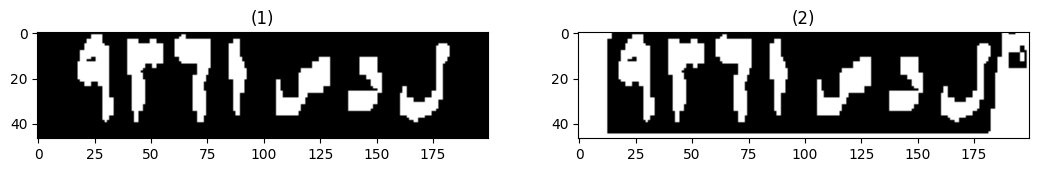

0.0052
area:4856.5
Ar:1.9836065573770492


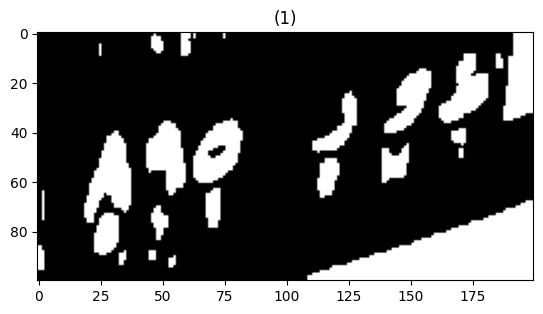

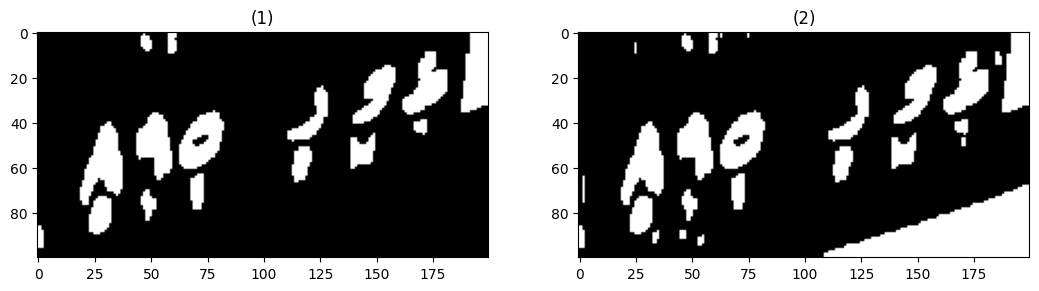

0.0038
area:6965.0
Ar:3.702127659574468


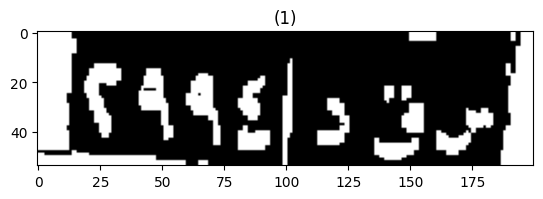

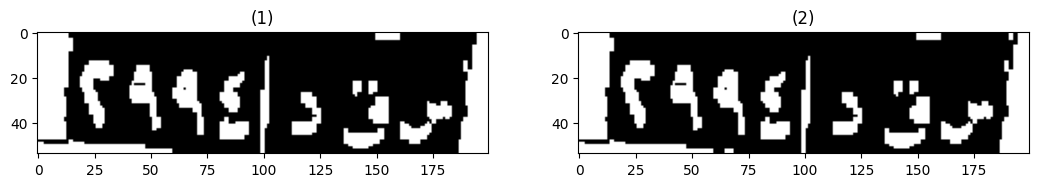

0.0038
area:12704.0
area:9147.5
Ar:2.5303030303030303


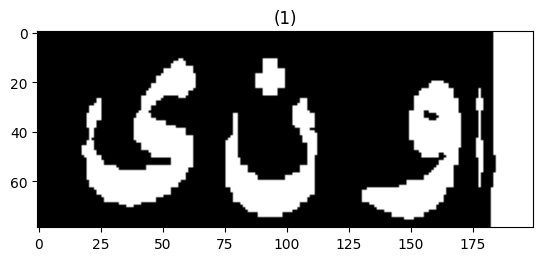

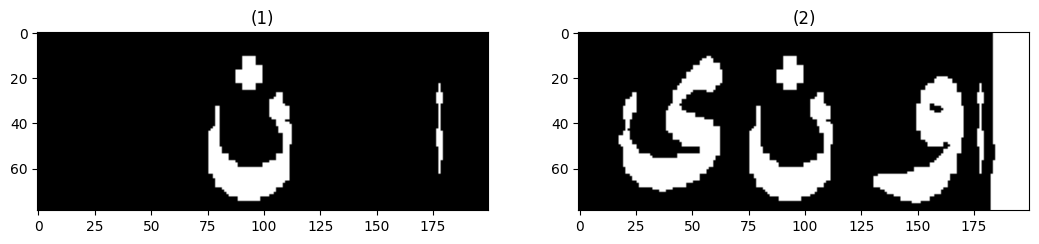

0.0075
area:6651.0
Ar:4.659574468085107


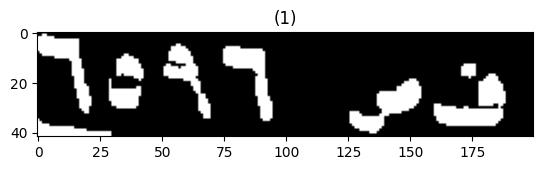

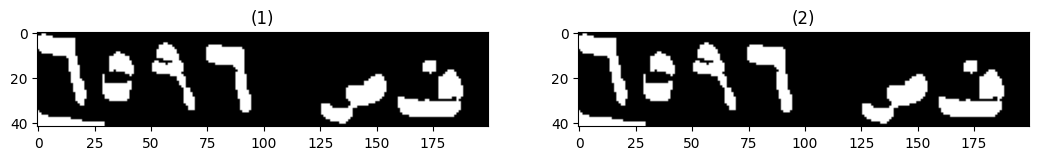

0.0092
area:4108.5
Ar:3.5238095238095237


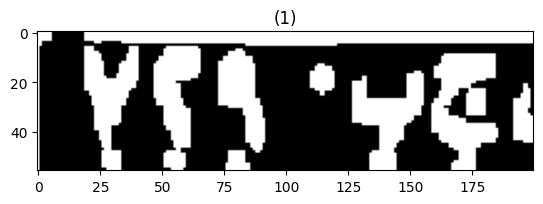

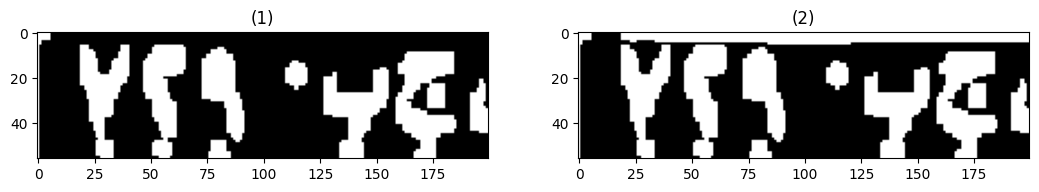

0.0078
area:6800.5
Ar:4.6923076923076925


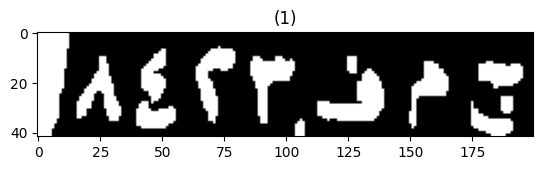

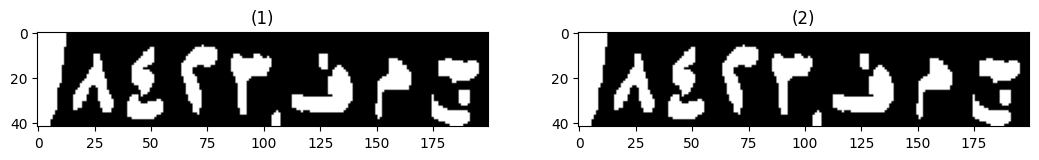

0.0119
****************************************************************************************************
area:4596.0
Ar:3.3255813953488373


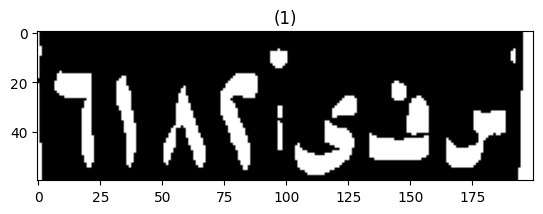

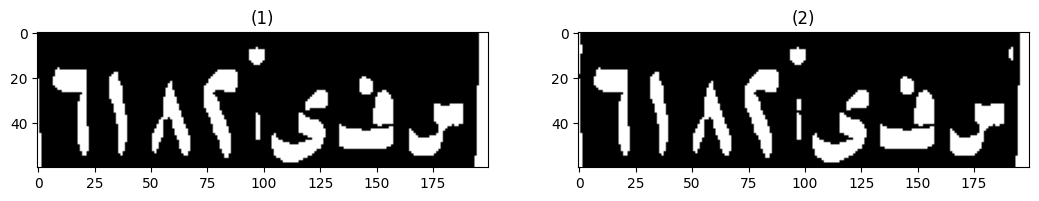

0.0008
area:6002.0
Ar:2.792452830188679


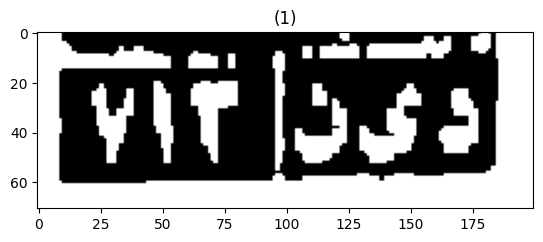

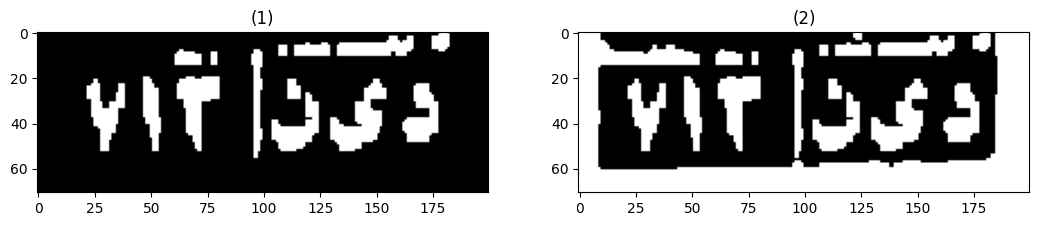

0.0072
area:7876.0
Ar:3.774193548387097


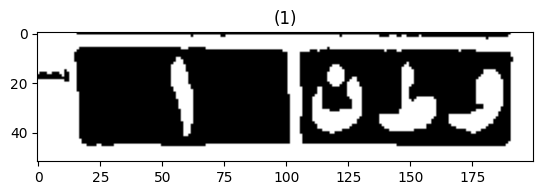

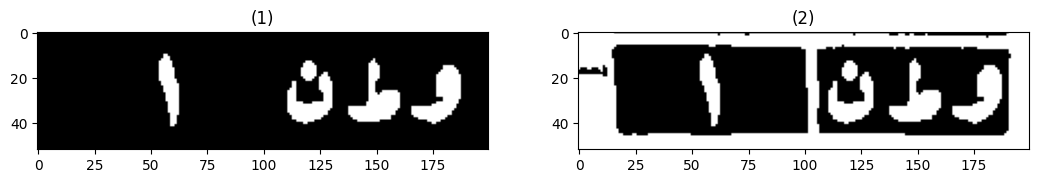

0.0017
area:3826.5
Ar:3.393939393939394


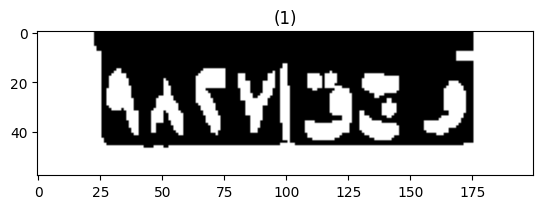

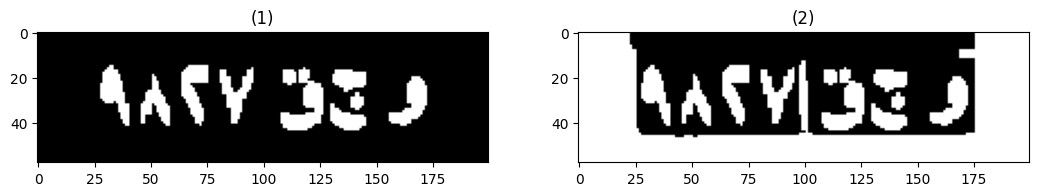

0.005
area:7567.5
Ar:4.809523809523809


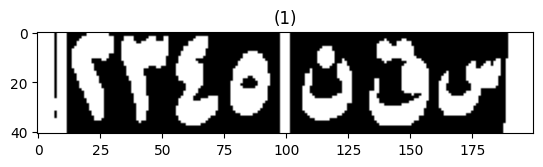

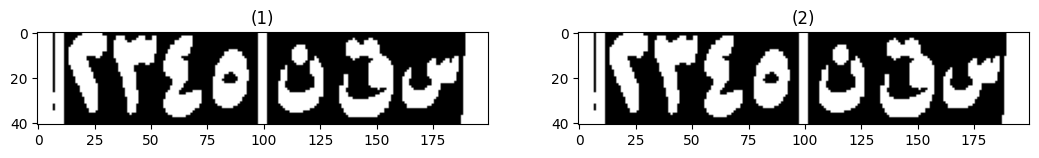

In [7]:
import os
images = os.listdir('images')
for image in images:
    enhance_plate(LPD(cv.imread('images/'+image)))
# LPD(cv.imread('0658.jpg'))

In [7]:
model = load("data/trained_model.pkl", mmap_mode="r")
data = []
result = []
car_letters = sorted(car_letters ,key=lambda x: x[1], reverse = True)
for i in car_letters:
    img = cv.resize(i[0],(32,64))
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    describtor= hog(gray,orientations=9,pixels_per_cell=(8,8), cells_per_block=(1, 1))
    data.append((describtor).flatten())

df_test = pd.DataFrame(data)
df_test = df_test.dropna(axis=1)
print(model.predict(df_test))

ValueError: at least one array or dtype is required